## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-12-26 20:08:15.958202


{1: 24.2,
 5: 25.4,
 10: 26.1,
 20: 26.9,
 30: 27.8,
 40: 29.2,
 50: 30.9,
 60: 32.6,
 70: 34.6,
 80: 36.8,
 90: 40.2,
 95: 43.1,
 99: 49.70100000000002}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2025-01-08 13:10:01.115885


{1: 8.5,
 5: 8.6,
 10: 8.7,
 20: 8.9,
 30: 9.0,
 40: 9.1,
 50: 9.1,
 60: 9.2,
 70: 9.3,
 80: 9.5,
 90: 9.7,
 95: 9.8,
 99: 10.2}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2025-01-23 11:52:18.919869


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev3)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49) (version 0.28-dev3)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49) (version 0.28-dev3)}}

In [6]:
def wildeford_max_gdp_frac():
    gdp_frac = sq.mixture([[0.9, sq.lognorm(1/500, 1/100)],
                           [0.1, sq.lognorm(1/100, 1/20)]])
    percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
    percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)
    compute_frac = gdp_frac * percent_spent_on_compute * percent_spent_on_largest_model
    return {'total_frac': gdp_frac, 'compute_frac': compute_frac}


base_flop_per_dollar = sq.lognorm(18.2, 19.4) # https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
# I'd use 1.43e18 FLOP/$ if renting cloud compute for training (significantly higher for serving a product, and significantly lower if using your own compute -- but then the number depends on how long you amortize it over).
# Source: If renting cloud compute, pricing seems to be $1.89-2.40 per H100 hour. (Jack Clark says $2 with bulk discounts.) Going with $2/hr, with the H100's 1.98e15 FLOP/s (FP8) and assuming 40% utilization (for training), that's 1.98e15*.4*60*60/2 = 1.43e18 FLOP/$.
# https://jack-clark.net/2024/03/28/what-does-1025-versus-1026-mean/ and https://gpus.llm-utils.org/h100-gpu-cloud-availability-and-pricing/
flop_frontier_penalty = sq.norm(0, 1)

# https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': np.array(tai_flop_size),
             'algo_doubling_rate_max': sq.lognorm(0.5, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': base_flop_per_dollar - flop_frontier_penalty,
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': np.array(initial_pay),
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'],
             'spend_doubling_time': sq.lognorm(0.5, 2, lclip=0.1),
             'nonscaling_delay': delay }

variables

{'initial_gdp': <Distribution> 23320000000000.0 * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) (version 0.28-dev3),
 'tai_flop_size': array([27.2, 24.5, 34.5, ..., 29.7, 27.3, 29.5]),
 'algo_doubling_rate_max': <Distribution> lognorm(lognorm_mean=1.42, lognorm_sd=0.83, norm_mean=0.2, norm_sd=0.54) (version 0.28-dev3),
 'algo_doubling_rate_min': <Distribution> lognorm(lognorm_mean=1.09, lognorm_sd=0.48, norm_mean=0.0, norm_sd=0.42) (version 0.28-dev3),
 'min_reduction': 2,
 'max_reduction': <Distribution> lognorm(lognorm_mean=7.56, lognorm_sd=3.93, norm_mean=1.9, norm_sd=0.49) (version 0.28-dev3),
 'initial_flop_per_dollar': <Distribution> lognorm(lognorm_mean=18.79, lognorm_sd=0.36, norm_mean=2.93, norm_sd=0.02) - norm(mean=0.5, sd=0.3) (version 0.28-dev3),
 'flop_halving_rate': <Distribution> norm(mean=2.5, sd=0.

## GDP Frac

### GDP

In [7]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000)
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '24.8 trillion',
 5: '24.9 trillion',
 10: '24.9 trillion',
 20: '25.0 trillion',
 30: '25.0 trillion',
 40: '25.1 trillion',
 50: '25.1 trillion',
 60: '25.1 trillion',
 70: '25.2 trillion',
 80: '25.2 trillion',
 90: '25.3 trillion',
 95: '25.3 trillion',
 99: '25.4 trillion'}

#### Total % of GDP spent on entire project

In [8]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 19426.01it/s]


{1: 0.00146,
 5: 0.00207,
 10: 0.00249,
 20: 0.0031,
 30: 0.00363,
 40: 0.00425,
 50: 0.00487,
 60: 0.00561,
 70: 0.0066,
 80: 0.00828,
 90: 0.01322,
 95: 0.02242,
 99: 0.04175}

In [9]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.146%',
 5: '0.207%',
 10: '0.249%',
 20: '0.31%',
 30: '0.363%',
 40: '0.425%',
 50: '0.487%',
 60: '0.561%',
 70: '0.66%',
 80: '0.828%',
 90: '1.322%',
 95: '2.242%',
 99: '4.175%'}

In [10]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '36.4 billion',
 5: '51.9 billion',
 10: '62.6 billion',
 20: '78.1 billion',
 30: '91.1 billion',
 40: '106.7 billion',
 50: '122.2 billion',
 60: '140.9 billion',
 70: '165.6 billion',
 80: '208.3 billion',
 90: '332.6 billion',
 95: '563.2 billion',
 99: '1.1 trillion'}

#### Total % of GDP spent on compute for largest model

In [11]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 6309.32it/s]


{1: '0.001%',
 5: '0.004%',
 10: '0.006%',
 20: '0.011%',
 30: '0.018%',
 40: '0.027%',
 50: '0.04%',
 60: '0.059%',
 70: '0.087%',
 80: '0.143%',
 90: '0.257%',
 95: '0.431%',
 99: '1.129%'}

In [12]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.001%',
 5: '0.004%',
 10: '0.006%',
 20: '0.011%',
 30: '0.018%',
 40: '0.027%',
 50: '0.04%',
 60: '0.059%',
 70: '0.087%',
 80: '0.143%',
 90: '0.257%',
 95: '0.431%',
 99: '1.129%'}

In [13]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '314.2 million',
 5: '908.4 million',
 10: '1.5 billion',
 20: '2.9 billion',
 30: '4.5 billion',
 40: '6.9 billion',
 50: '10.0 billion',
 60: '14.8 billion',
 70: '21.9 billion',
 80: '35.8 billion',
 90: '64.4 billion',
 95: '108.3 billion',
 99: '284.5 billion'}

In [14]:
def model():
    frac = wildeford_max_gdp_frac()
    return frac['total_frac'] / frac['compute_frac']

sq.get_percentiles(sq.sample(model, verbose=True, n=5000), digits=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3744.31it/s]


{1: 0.4,
 5: 0.9,
 10: 1.7,
 20: 3.5,
 30: 6.0,
 40: 9.2,
 50: 13.8,
 60: 20.7,
 70: 33.3,
 80: 56.1,
 90: 118.8,
 95: 215.4,
 99: 794.3}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 25.5 log FLOP (~31.6 septillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.1 quintillion) per 2025$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.4 septillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.7 billion).
* This doubles every 1.1 year to a max of 0.037765% of GDP (initially ~9.5 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 25.5 logFLOP which costs 7.0 log 2025$USD to buy vs. WTP at 9.1 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 6 more ye

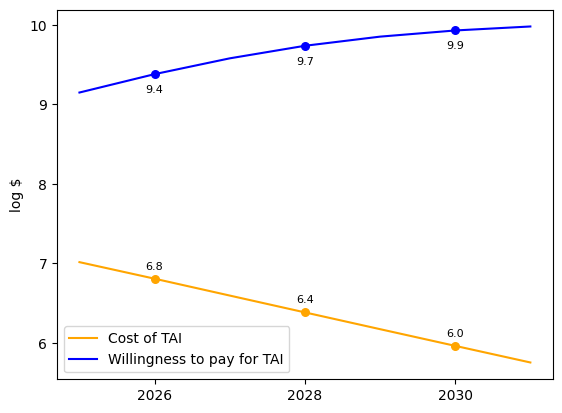



## SAMPLE RUN 2 ##

In this simulation:
* It takes 38.2 log FLOP (~158.5 thousand decillion) for transformative capabilities.
* Every 2.2 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 17.6 log FLOP (~419.7 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6.5 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 0.8 year to a max of 0.056048% of GDP (initially ~14.0 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 38.2 logFLOP which costs 20.6 log 2025$USD to buy vs. WTP at 9.0 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 38.1 logFLOP which costs 20.3 log 2025$USD to buy vs. WTP at 9.4 (buys 27.1 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 37.9 logFLOP which costs 20.1 log 2025$USD to buy vs. WTP at 9.7 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
2028 - TAI takes 37.8 logFLOP whic

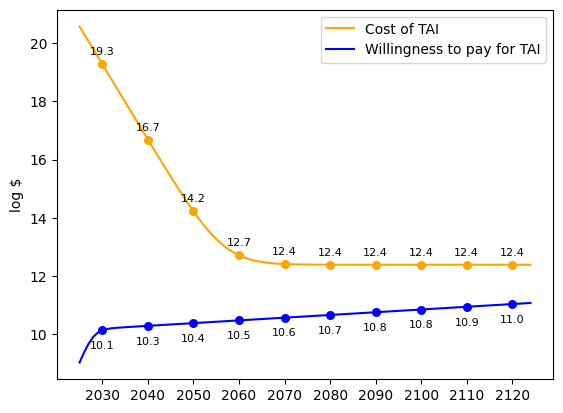



## SAMPLE RUN 3 ##

In this simulation:
* It takes 31.9 log FLOP (~79.4 nonillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~616.1 quadrillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~736.7 million).
* This doubles every 1.1 year to a max of 0.04067% of GDP (initially ~10.2 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 31.9 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 8.8 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 31.7 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 9.1 (buys 27.0 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 31.6 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 9.3 (buys 27.3 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 31.4 logFLOP which costs 

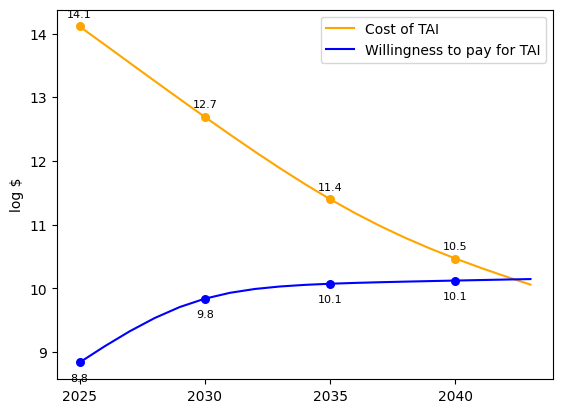



## RUN TIMELINES MODEL ##
Generating Bayes net with 12 cores...


10044it [00:12, 829.47it/s]                                                                                                                                                                                                                          


Shuffling data...
Writing data...
Waiting for other cores...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1367.37it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['1%: 2025',
 '2%: 2026',
 '3%: 2026',
 '4%: 2026',
 '5%: 2027',
 '10%: 2027',
 '15%: 2028',
 '20%: 2028',
 '25%: 2029',
 '35%: 2030',
 '50%: 2036',
 '60%: 2046',
 '75%: 2065',
 '80%: 2085',
 '90%: >2125',
 '95%: >2125']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['1%: 0 years from now',
 '2%: 1 years from now',
 '3%: 1 years from now',
 '4%: 1 years from now',
 '5%: 2 years from now',
 '10%: 2 years from now',
 '15%: 3 years from now',
 '20%: 3 years from now',
 '25%: 4 years from now',
 '35%: 5 years from now',
 '50%: 11 years from now',
 '60%: 21 years from now',
 '75%: 40 years from now',
 '80%: 60 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 30 years from now)


## TAI ARRIVAL DATE BY BIN ##
2025-2026: 4.1%
2027-2029: 26.2%
2030-2034: 18.0%
2035-2039: 4.1



## GDP Over Time ##
Year: 2025 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~25.9 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.2 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.7 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~26.8 trillion) 80% CI 13.4 (~26.2 trillion) - 13.4 (~27.5 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~27.4 trillion) 80% CI 13.4 (~26.7 trillion) - 13.5 (~28.3 trillion)
Year: 2030 - GDP log 2024$USD 13.4 (~28.0 trillion) 80% CI 13.4 (~27.1 trillion) - 13.5 (~29.1 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~28.6 trillion) 80% CI 13.4 (~27.5 trillion) - 13.5 (~29.9 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~29.3 trillion) 80% CI 13.4 (~28.0 trillion) - 13.5 (~30.8 trillion)
Year: 2033 - GDP log 2024$USD 13.5 (~29.9 trillion) 80% CI 13.5 (~28.4 trillion) - 13.5 (~31.7 trillion)
Year: 2034 - GDP log 2024$USD 13.

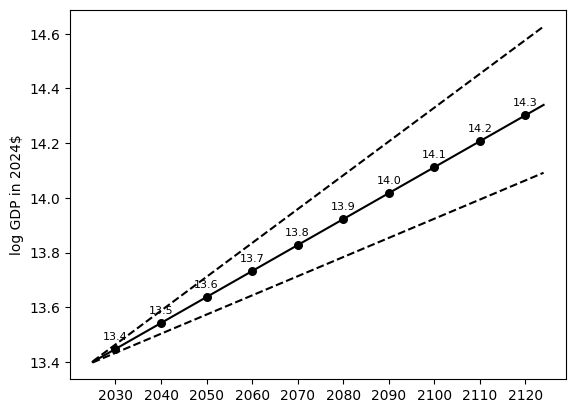

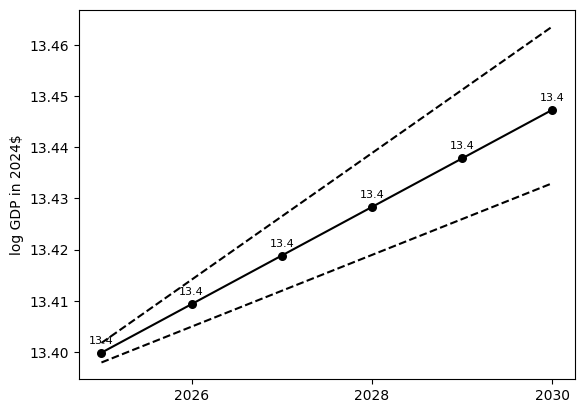



## Willingness to Pay Over Time (Total infrastructure) ##
Year: 2025 - willingness log 2024$USD per year for total infrastructure 10.5 (~30.7 billion) 80% CI 9.8 (~6.2 billion) - 11.4 (~232.2 billion)
Year: 2026 - willingness log 2024$USD per year for total infrastructure 10.7 (~53.6 billion) 80% CI 10.1 (~11.9 billion) - 11.6 (~360.6 billion)
Year: 2027 - willingness log 2024$USD per year for total infrastructure 10.9 (~86.9 billion) 80% CI 10.3 (~18.6 billion) - 11.7 (~547.3 billion)
Year: 2028 - willingness log 2024$USD per year for total infrastructure 11.1 (~128.5 billion) 80% CI 10.4 (~24.0 billion) - 11.9 (~805.1 billion)
Year: 2029 - willingness log 2024$USD per year for total infrastructure 11.2 (~171.5 billion) 80% CI 10.4 (~27.2 billion) - 12.1 (~1.1 trillion)
Year: 2030 - willingness log 2024$USD per year for total infrastructure 11.3 (~208.9 billion) 80% CI 10.5 (~28.9 billion) - 12.2 (~1.5 trillion)
Year: 2031 - willingness log 2024$USD per year for total infrastructure

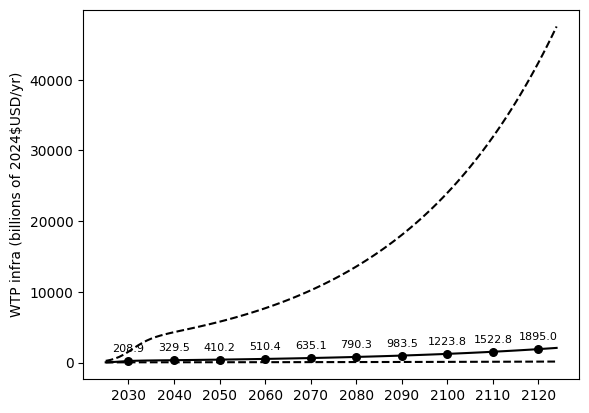

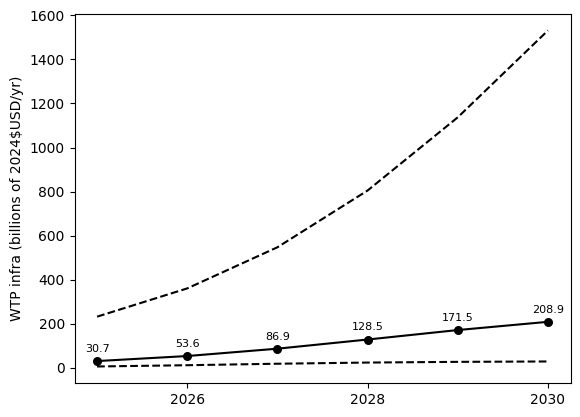



## Willingness to Pay Over Time (Largest single model) ##
Year: 2025 - willingness log 2024$USD per year for largest single model 9.1 (~1.2 billion) 80% CI 8.8 (~616.1 million) - 9.5 (~2.9 billion)
Year: 2026 - willingness log 2024$USD per year for largest single model 9.3 (~2.1 billion) 80% CI 9.1 (~1.2 billion) - 9.7 (~4.5 billion)
Year: 2027 - willingness log 2024$USD per year for largest single model 9.5 (~3.5 billion) 80% CI 9.3 (~1.9 billion) - 9.8 (~6.8 billion)
Year: 2028 - willingness log 2024$USD per year for largest single model 9.7 (~5.1 billion) 80% CI 9.4 (~2.4 billion) - 10.0 (~10.1 billion)
Year: 2029 - willingness log 2024$USD per year for largest single model 9.8 (~6.9 billion) 80% CI 9.4 (~2.7 billion) - 10.2 (~14.2 billion)
Year: 2030 - willingness log 2024$USD per year for largest single model 9.9 (~8.4 billion) 80% CI 9.5 (~2.9 billion) - 10.3 (~19.1 billion)
Year: 2031 - willingness log 2024$USD per year for largest single model 10.0 (~9.5 billion) 80% CI 9.5 (

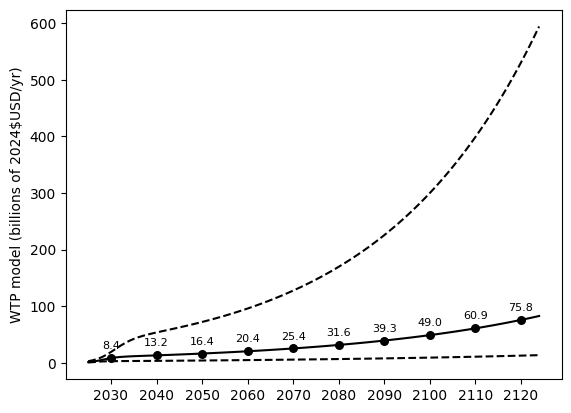

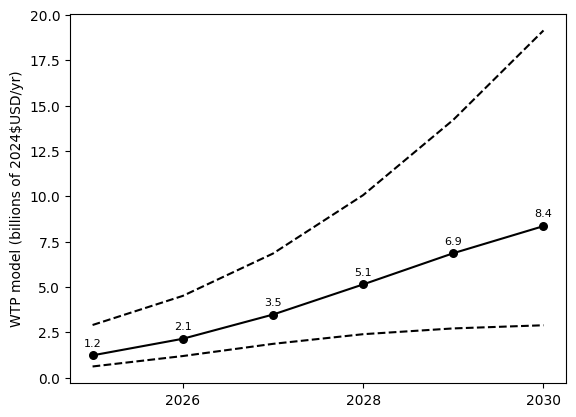



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2025 - logFLOP needed for TAI 30.6 (~4.5 nonillion) 80% CI 27.0 (~955.0 septillion) - 36.7 (~5.2 thousand decillion)
Year: 2026 - logFLOP needed for TAI 30.4 (~2.3 nonillion) 80% CI 26.6 (~398.1 septillion) - 36.5 (~3.2 thousand decillion)
Year: 2027 - logFLOP needed for TAI 30.1 (~1.2 nonillion) 80% CI 26.2 (~167.6 septillion) - 36.3 (~2.0 thousand decillion)
Year: 2028 - logFLOP needed for TAI 29.8 (~605.4 octillion) 80% CI 25.9 (~73.8 septillion) - 36.1 (~1.2 thousand decillion)
Year: 2029 - logFLOP needed for TAI 29.5 (~325.4 octillion) 80% CI 25.6 (~35.7 septillion) - 35.9 (~741.7 decillion)
Year: 2030 - logFLOP needed for TAI 29.3 (~185.2 octillion) 80% CI 25.3 (~20.2 septillion) - 35.7 (~456.0 decillion)
Year: 2031 - logFLOP needed for TAI 29.1 (~115.0 octillion) 80% CI 25.1 (~13.9 septillion) - 35.4 (~281.1 decillion)
Year: 2032 - logFLOP needed for TAI 28.9 (~79.9 octillion) 80% CI 25.1 (~11.3 septillion

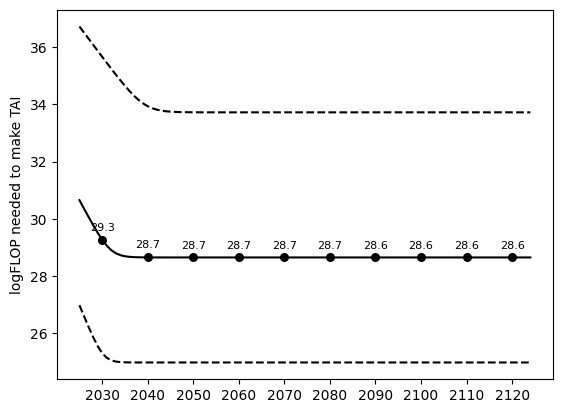

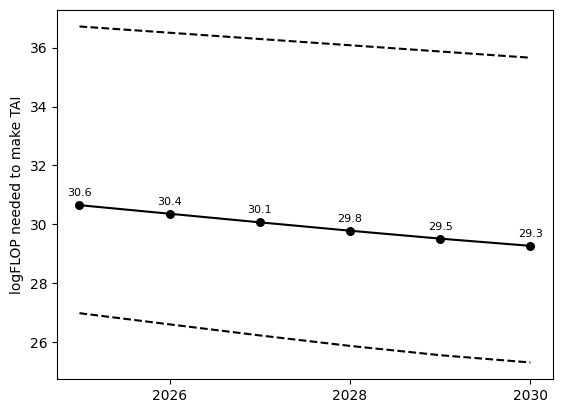



## FLOP per Dollar (Given Declining Costs) ##
Year: 2025 - logFLOP per 2024$1USD 18.3 (~2.0 quintillion) 80% CI 17.9 (~758.4 quadrillion) - 18.7 (~4.7 quintillion)
Year: 2026 - logFLOP per 2024$1USD 18.4 (~2.6 quintillion) 80% CI 18.0 (~1.0 quintillion) - 18.8 (~6.1 quintillion)
Year: 2027 - logFLOP per 2024$1USD 18.5 (~3.4 quintillion) 80% CI 18.1 (~1.4 quintillion) - 18.9 (~7.8 quintillion)
Year: 2028 - logFLOP per 2024$1USD 18.7 (~4.5 quintillion) 80% CI 18.3 (~1.9 quintillion) - 19.0 (~10.0 quintillion)
Year: 2029 - logFLOP per 2024$1USD 18.8 (~5.9 quintillion) 80% CI 18.4 (~2.6 quintillion) - 19.1 (~12.9 quintillion)
Year: 2030 - logFLOP per 2024$1USD 18.9 (~7.8 quintillion) 80% CI 18.5 (~3.5 quintillion) - 19.2 (~16.7 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.0 (~10.4 quintillion) 80% CI 18.7 (~4.8 quintillion) - 19.3 (~21.4 quintillion)
Year: 2032 - logFLOP per 2024$1USD 19.1 (~13.7 quintillion) 80% CI 18.8 (~6.6 quintillion) - 19.4 (~27.6 quintillion)
Year: 2033 - lo

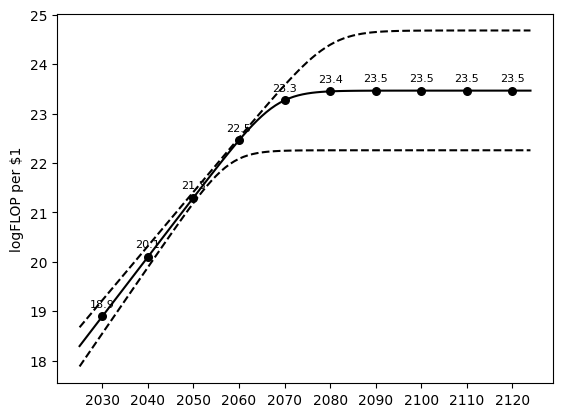

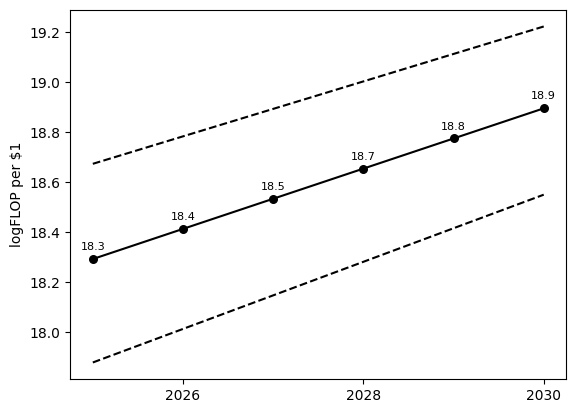



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

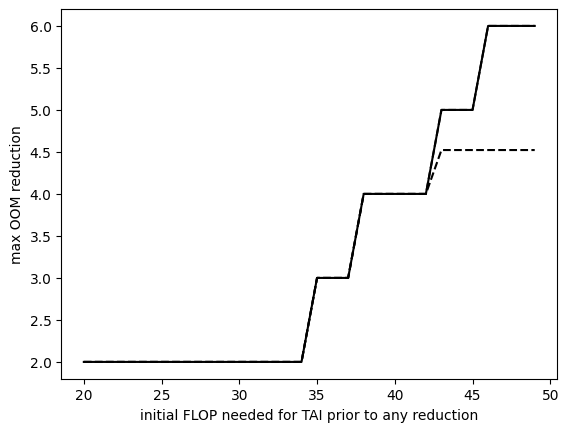



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.26yrs (80% CI: 1.99 to 1.99)
TAI log FLOP 21 -> algo doubling rate 1.26yrs (80% CI: 1.99 to 1.99)
TAI log FLOP 22 -> algo doubling rate 1.26yrs (80% CI: 1.99 to 1.99)
TAI log FLOP 23 -> algo doubling rate 1.26yrs (80% CI: 1.99 to 1.99)
TAI log FLOP 24 -> algo doubling rate 1.26yrs (80% CI: 1.99 to 1.99)
TAI log FLOP 25 -> algo doubling rate 1.26yrs (80% CI: 1.99 to 1.99)
TAI log FLOP 26 -> algo doubling rate 1.26yrs (80% CI: 1.99 to 1.99)
TAI log FLOP 27 -> algo doubling rate 1.26yrs (80% CI: 1.99 to 1.99)
TAI log FLOP 28 -> algo doubling rate 1.26yrs (80% CI: 1.99 to 1.99)
TAI log FLOP 29 -> algo doubling rate 1.26yrs (80% CI: 1.99 to 1.99)
TAI log FLOP 30 -> algo doubling rate 1.26yrs (80% CI: 1.99 to 1.99)
TAI log FLOP 31 -> algo doubling rate 1.0yrs (80% CI: 1.49 to 1.49)
TAI log FLOP 32 -> algo doubling rate 1.0yrs (80% CI: 0.99 to 0.99)
TAI log FLOP 33 -> algo doubling rate 1.0yrs (80% CI

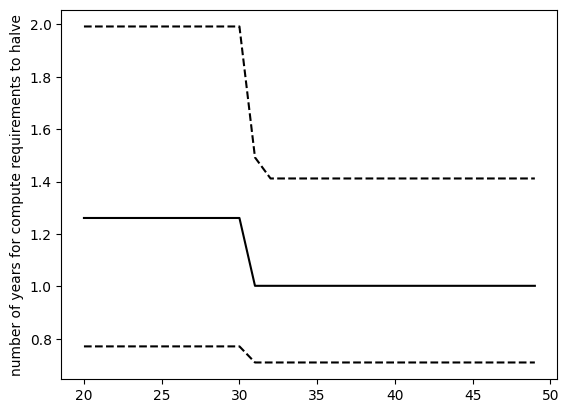



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2025 - 12.4 log 2024$USD to buy TAI (~2.3 trillion) 80% CI 9.1 (~1.3 billion) - 18.0 (~1.1 quintillion)
Year: 2026 - 11.9 log 2024$USD to buy TAI (~880.8 billion) 80% CI 8.6 (~385.5 million) - 17.7 (~530.5 quadrillion)
Year: 2027 - 11.5 log 2024$USD to buy TAI (~340.8 billion) 80% CI 8.1 (~119.2 million) - 17.4 (~252.5 quadrillion)
Year: 2028 - 11.1 log 2024$USD to buy TAI (~134.3 billion) 80% CI 7.6 (~38.6 million) - 17.1 (~120.3 quadrillion)
Year: 2029 - 10.7 log 2024$USD to buy TAI (~54.7 billion) 80% CI 7.1 (~13.7 million) - 16.8 (~57.3 quadrillion)
Year: 2030 - 10.4 log 2024$USD to buy TAI (~23.6 billion) 80% CI 6.8 (~5.7 million) - 16.4 (~27.4 quadrillion)
Year: 2031 - 10.0 log 2024$USD to buy TAI (~11.1 billion) 80% CI 6.5 (~2.9 million) - 16.1 (~13.1 quadrillion)
Year: 2032 - 9.8 log 2024$USD to buy TAI (~5.9 billion) 80% CI 6.2 (~1.7 million) - 15.8 (~6.3 quadrillion)
Year: 2033 -

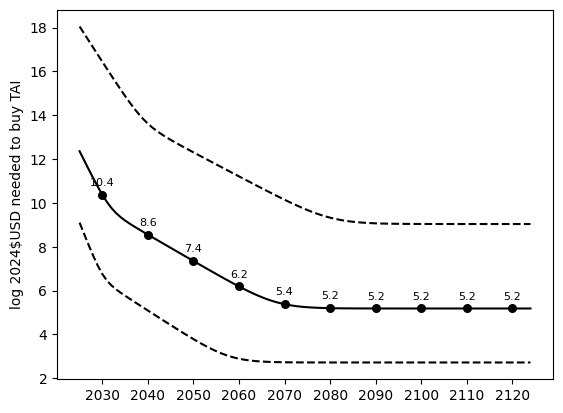

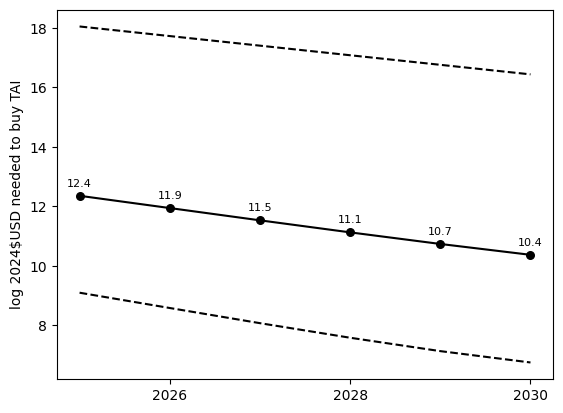



## Actual FLOP at Max Spend ##
Year: 2025 - max log FLOP 27.4 (~2.4 octillion) 80% CI 26.7 (~467.3 septillion) - 28.1 (~13.7 octillion)
Year: 2026 - max log FLOP 27.7 (~5.6 octillion) 80% CI 27.1 (~1.2 octillion) - 28.4 (~27.3 octillion)
Year: 2027 - max log FLOP 28.1 (~11.9 octillion) 80% CI 27.4 (~2.6 octillion) - 28.7 (~53.4 octillion)
Year: 2028 - max log FLOP 28.4 (~23.2 octillion) 80% CI 27.7 (~4.6 octillion) - 29.0 (~101.1 octillion)
Year: 2029 - max log FLOP 28.6 (~40.8 octillion) 80% CI 27.8 (~7.1 octillion) - 29.3 (~183.9 octillion)
Year: 2030 - max log FLOP 28.8 (~65.5 octillion) 80% CI 28.0 (~10.2 octillion) - 29.5 (~318.8 octillion)
Year: 2031 - max log FLOP 29.0 (~98.3 octillion) 80% CI 28.2 (~14.4 octillion) - 29.7 (~524.6 octillion)
Year: 2032 - max log FLOP 29.1 (~140.7 octillion) 80% CI 28.3 (~20.1 octillion) - 29.9 (~820.8 octillion)
Year: 2033 - max log FLOP 29.3 (~196.2 octillion) 80% CI 28.4 (~27.9 octillion) - 30.1 (~1.2 nonillion)
Year: 2034 - max log FLOP 29.

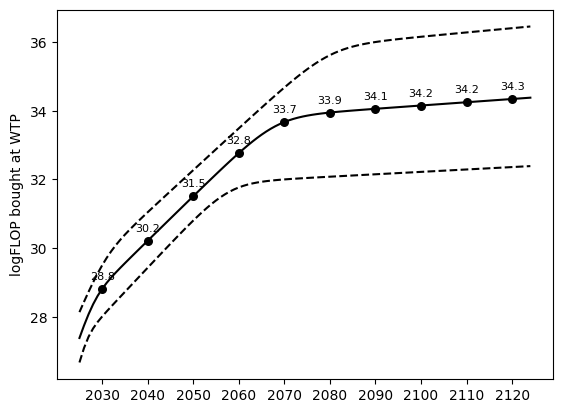

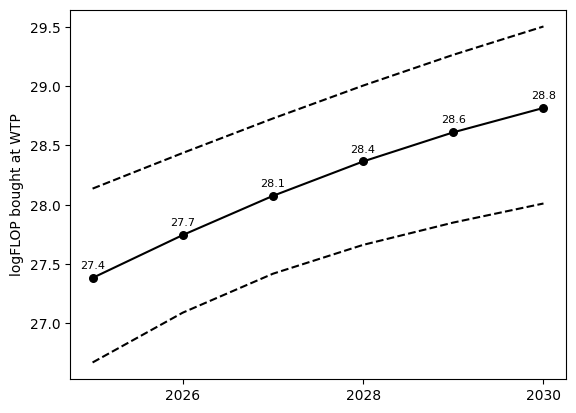



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2025 - max log effective 2024-FLOP 27.4 (~2.4 octillion) 80% CI 26.7 (~467.3 septillion) - 28.1 (~13.7 octillion)
Year: 2026 - max log effective 2024-FLOP 28.0 (~10.9 octillion) 80% CI 27.3 (~2.0 octillion) - 28.9 (~72.5 octillion)
Year: 2027 - max log effective 2024-FLOP 28.7 (~45.6 octillion) 80% CI 27.8 (~6.8 octillion) - 29.6 (~374.5 octillion)
Year: 2028 - max log effective 2024-FLOP 29.2 (~171.0 octillion) 80% CI 28.3 (~19.2 octillion) - 30.3 (~1.9 nonillion)
Year: 2029 - max log effective 2024-FLOP 29.7 (~560.1 octillion) 80% CI 28.7 (~47.1 octillion) - 30.9 (~8.7 nonillion)
Year: 2030 - max log effective 2024-FLOP 30.2 (~1.6 nonillion) 80% CI 29.0 (~106.8 octillion) - 31.6 (~37.3 nonillion)
Year: 2031 - max log effective 2024-FLOP 30.6 (~3.8 nonillion) 80% CI 29.4 (~230.7 octillion) - 32.1 (~136.6 nonillion)
Year: 2032 - max log effective 2024-FLOP 30.9 (~7.9 nonillion) 80% CI 29.7

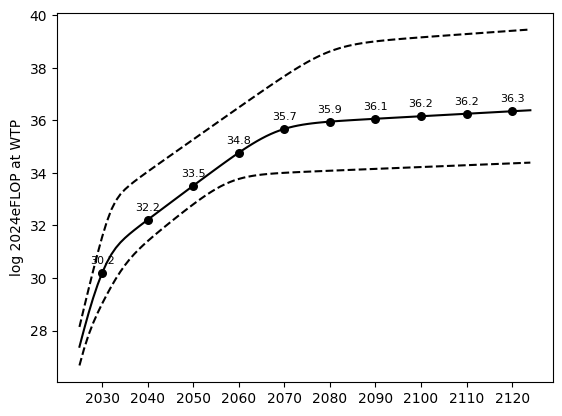

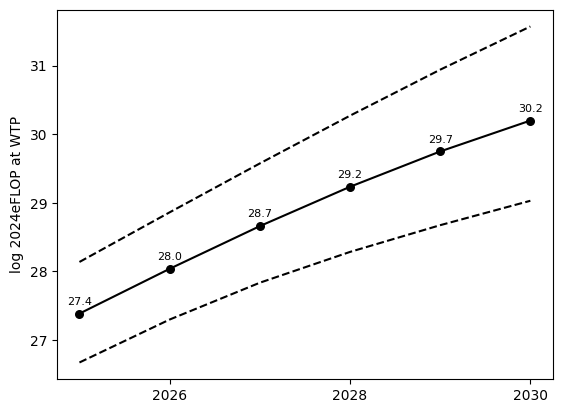


## TAI FLOP SIZE ##
{1: 24.0,
 5: 25.4,
 10: 26.1,
 20: 26.98,
 30: 27.9,
 40: 29.2,
 50: 30.65,
 60: 32.5,
 70: 34.4,
 80: 36.720000000000006,
 90: 40.3,
 95: 42.80499999999999,
 99: 48.0}


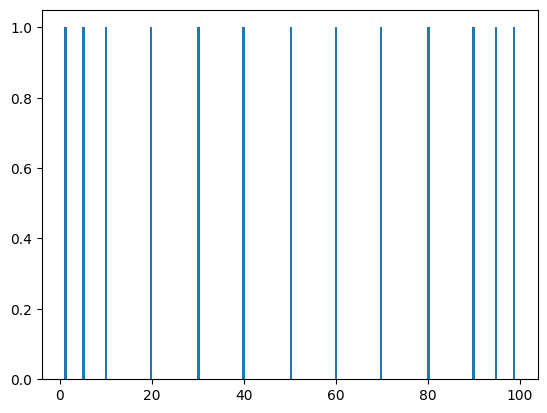



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 2.0812223356547688,
 5: 3.0864355646056145,
 10: 3.5993462419748647,
 20: 4.522399268523745,
 30: 5.211390726118856,
 40: 5.988588993827423,
 50: 6.743864250579876,
 60: 7.51310946206522,
 70: 8.627720798145011,
 80: 10.116886125696858,
 90: 12.440590367418107,
 95: 15.29705014266882,
 99: 21.394653136842933}


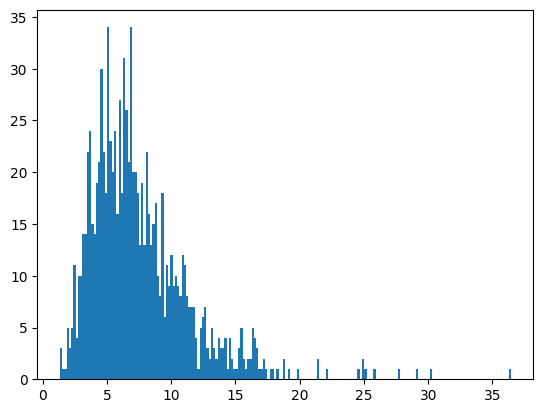



## MIN ALGO DOUBLING RATE ##
{1: 0.40991177453470473,
 5: 0.5074491841764033,
 10: 0.5957130308170949,
 20: 0.7092650792740308,
 30: 0.8192743528534837,
 40: 0.9182169345588531,
 50: 1.0020055458069133,
 60: 1.1006632742421956,
 70: 1.2369611204824862,
 80: 1.4119039482811642,
 90: 1.6308081569153412,
 95: 1.9318209697465378,
 99: 2.473201879991656}


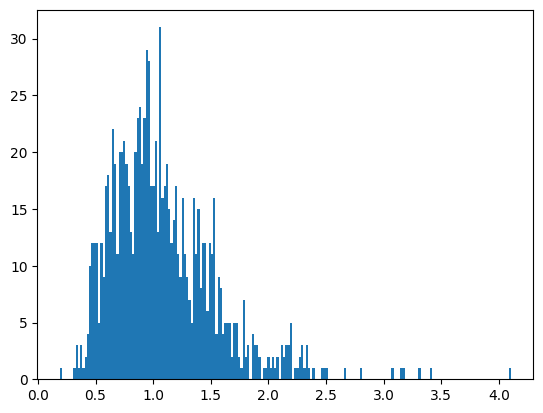



## MAX ALGO DOUBLING RATE ##
{1: 0.37318833676953234,
 5: 0.4935279785538914,
 10: 0.5965853728280085,
 20: 0.7706900171080531,
 30: 0.9163720808994409,
 40: 1.0816419636019106,
 50: 1.2610309074649162,
 60: 1.4421392991605937,
 70: 1.6984473527257342,
 80: 1.9923077689010151,
 90: 2.469115137526276,
 95: 2.9936668035369505,
 99: 4.371427108368862}


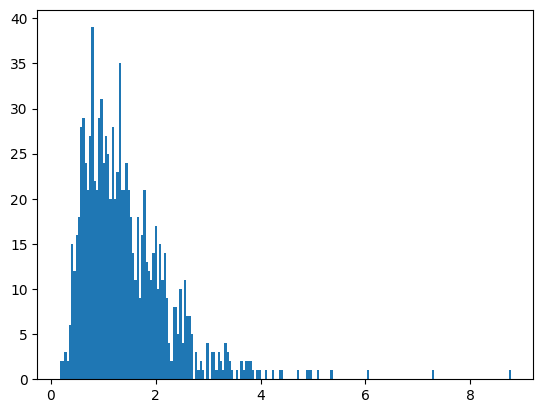



## INITIAL FLOP PER DOLLAR ##
{1: 17.304794666638493,
 5: 17.52001988698963,
 10: 17.683987378516708,
 20: 17.879937289615413,
 30: 18.03262839150919,
 40: 18.16881141225395,
 50: 18.2929641668998,
 60: 18.395679656394865,
 70: 18.514915314948194,
 80: 18.673112483138233,
 90: 18.893428084922384,
 95: 19.08662166492515,
 99: 19.428571101074187}


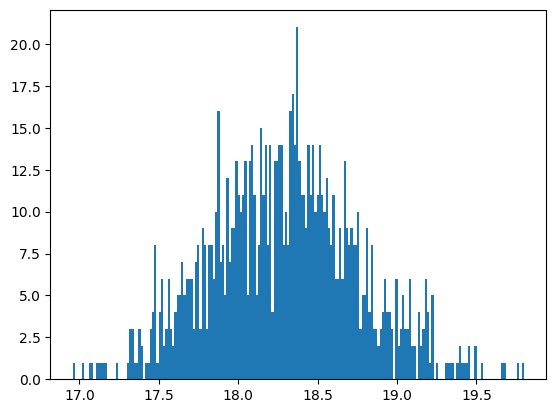



## FLOP HALVING RATE ##
{1: 1.78273292067878,
 5: 1.9851304443632902,
 10: 2.1174126700124125,
 20: 2.2465162059245385,
 30: 2.3323964015061107,
 40: 2.4173620264057387,
 50: 2.5016355187499246,
 60: 2.573333888268424,
 70: 2.6530091231916737,
 80: 2.7447876500401756,
 90: 2.90038994120266,
 95: 3.0055602387558387,
 99: 3.212383826318093}


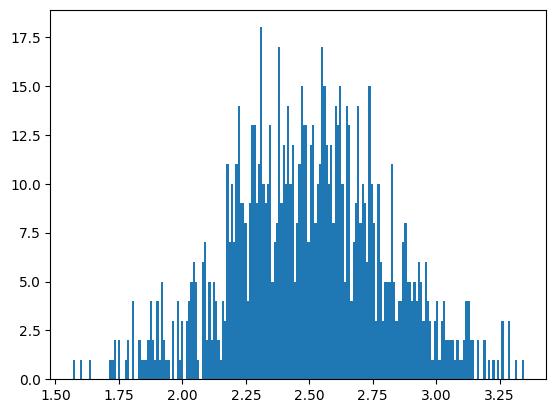



## MAX FLOP PER DOLLAR ##
{1: 20.10717037590075,
 5: 21.239951953169918,
 10: 21.66290859084871,
 20: 22.257259827893133,
 30: 22.807221414714174,
 40: 23.13740579127491,
 50: 23.465032721535398,
 60: 23.86315976262773,
 70: 24.2323885649296,
 80: 24.682797807821984,
 90: 25.40126329441298,
 95: 26.036729796030126,
 99: 27.2711267663183}


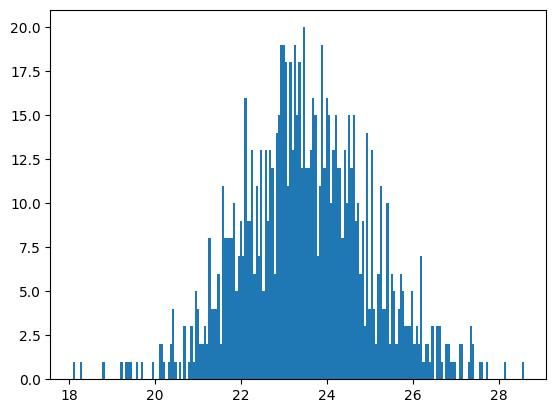



## INITIAL PAY ##
{1: 8.5,
 5: 8.7,
 10: 8.8,
 20: 8.9,
 30: 9.0,
 40: 9.1,
 50: 9.149999999999999,
 60: 9.2,
 70: 9.3,
 80: 9.5,
 90: 9.7,
 95: 9.8,
 99: 10.2}


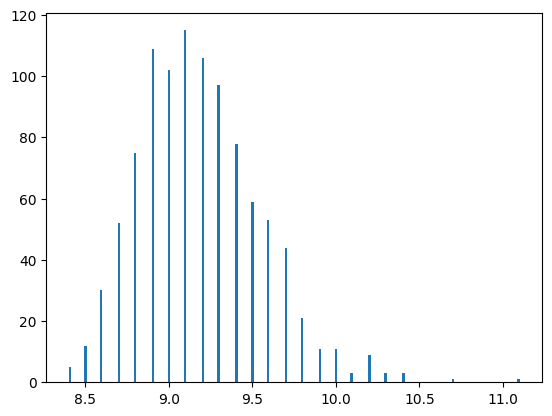



## INITIAL GDP ##
{1: 24802588209798.902,
 5: 24896576338620.82,
 10: 24946925937766.63,
 20: 25000116206697.29,
 30: 25048293809473.715,
 40: 25079600404013.633,
 50: 25110578117511.25,
 60: 25143859567227.043,
 70: 25183035892526.55,
 80: 25220564437348.016,
 90: 25271768322195.984,
 95: 25309575293462.74,
 99: 25383694343664.574}


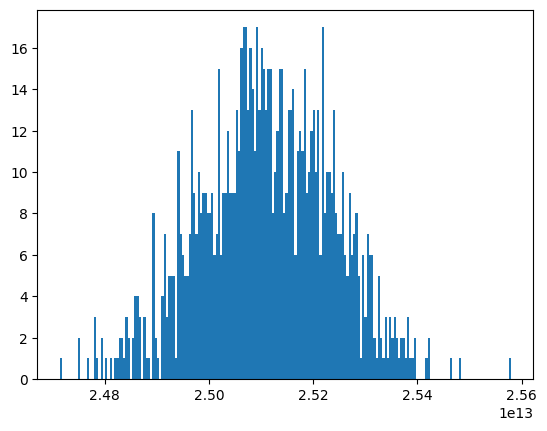



## GDP GROWTH ##
{1: 1.0052148815224347,
 5: 1.0102614546417619,
 10: 1.0129566782926218,
 20: 1.016266991713202,
 30: 1.0185870690970285,
 40: 1.020498539103179,
 50: 1.0221036307600717,
 60: 1.0240975857401469,
 70: 1.026257047219074,
 80: 1.0288972805187693,
 90: 1.032050549679372,
 95: 1.0342190351353748,
 99: 1.0390941714071706}


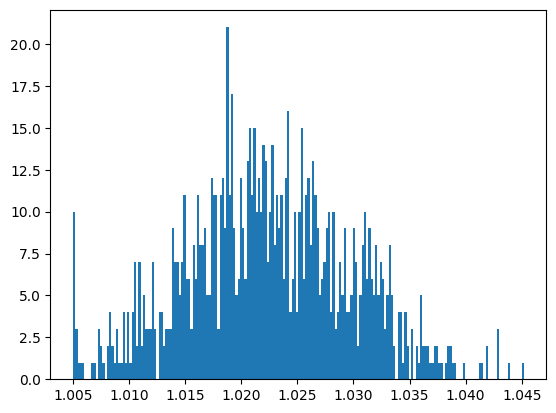



## MAX GDP FRAC ##
{1: 1.0870251100569539e-05,
 5: 3.204133728183822e-05,
 10: 5.345343368516533e-05,
 20: 0.00010984446247428364,
 30: 0.00017222321061171217,
 40: 0.00025880848304740727,
 50: 0.00037825626730538843,
 60: 0.0005568706150069475,
 70: 0.0008477441002411941,
 80: 0.0014041359228591035,
 90: 0.0026482603974122554,
 95: 0.004248772101432598,
 99: 0.00816345352129465}


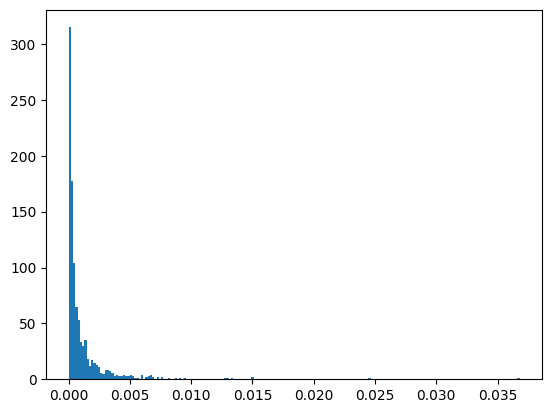



## SPEND DOUBLING TIME ##
{1: 0.3677480051943321,
 5: 0.5082985151562455,
 10: 0.5919548103564716,
 20: 0.7210827229815414,
 30: 0.8061810440267949,
 40: 0.9291218111742807,
 50: 1.0403722670024842,
 60: 1.14746607244143,
 70: 1.249143653041033,
 80: 1.4243774878999231,
 90: 1.705272181702803,
 95: 1.9409872028317703,
 99: 2.6197571487514955}


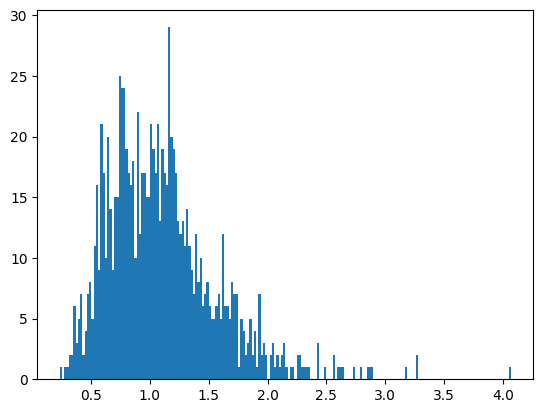





## Nonscaling delay ##
There are 3 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 1,
 5: 1,
 10: 1,
 20: 2,
 30: 2,
 40: 2,
 50: 2,
 60: 3,
 70: 3,
 80: 4,
 90: 5,
 95: 7,
 99: 20}
## Chance of nonscaling delay ##


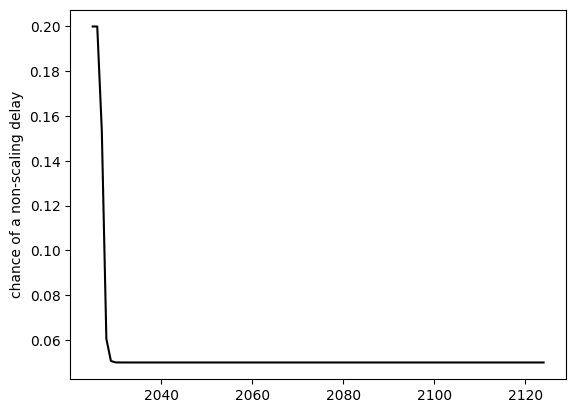

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - chan

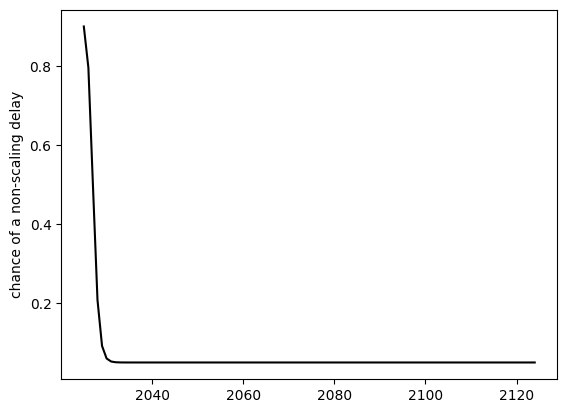

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - cha

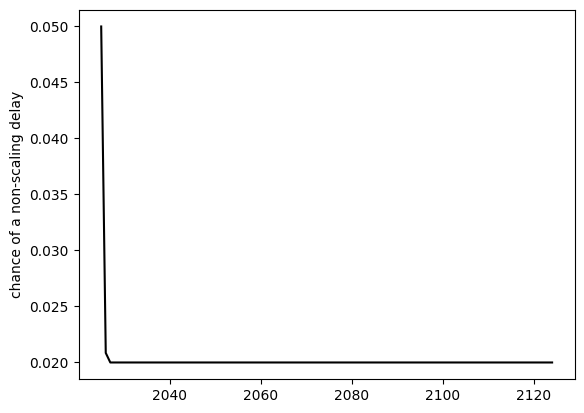

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2035 - chance 

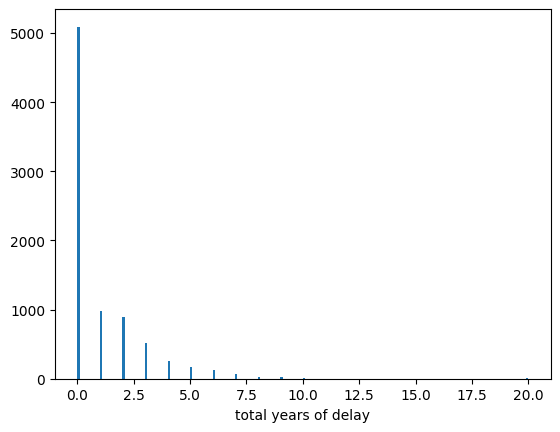

In [15]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=max(1, os.cpu_count() - 2),
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 38.0 log FLOP (~100.0 thousand decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~16.3 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~233.4 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 0.8 year to a max of 0.084767% of GDP (initially ~21.2 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 38.0 logFLOP which costs 18.8 log 2025$USD to buy vs. WTP at 9.1 (buys 28.3 log FLOP or 28.3 2025-log-eFLOP)
2026 - TAI takes 37.6 logFLOP which costs 18.2 log 2025$USD to buy vs. WTP at 9.4 (buys 28.7 log FLOP or 29.2 2025-log-eFLOP)
2027 - TAI takes 37.2 logFLOP which costs 17.7 log 2025$USD to buy vs. WTP at 9.7 (buys 29.2 log FLOP or 30.0 2025-log-eFLOP)
2028 - TAI takes 36.7 logFLOP w

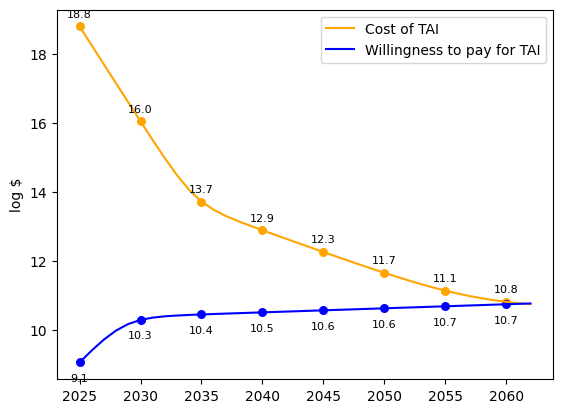

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 39.1 log FLOP (~1.3 million decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 17.5 log FLOP (~298.5 quadrillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~888.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.0 billion).
* This doubles every 2.1 year to a max of 0.047103% of GDP (initially ~11.9 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 39.1 logFLOP which costs 21.6 log 2025$USD to buy vs. WTP at 9.4 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 38.8 logFLOP which costs 21.2 log 2025$USD to buy vs. WTP at 9.5 (buys 27.1 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 38.4 logFLOP which costs 20.7 log 2025$USD to buy vs. WTP at 9.6 (buys 27.3 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 38.1 logFLOP whi

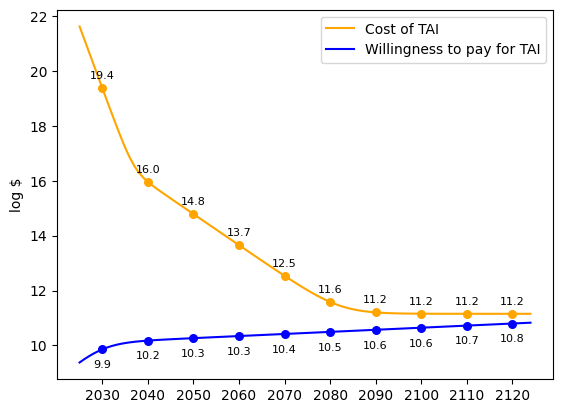

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 41.6 log FLOP (~398.1 million decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.6 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~202.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~889.6 million).
* This doubles every 1.4 year to a max of 0.0321% of GDP (initially ~8.1 billion 2025$USD).
* GDP grows at a rate of 1.034x per year.
---
2025 - TAI takes 41.6 logFLOP which costs 22.9 log 2025$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 41.3 logFLOP which costs 22.5 log 2025$USD to buy vs. WTP at 9.1 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 40.9 logFLOP which costs 22.0 log 2025$USD to buy vs. WTP at 9.3 (buys 28.2 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 40.6 logFLOP whic

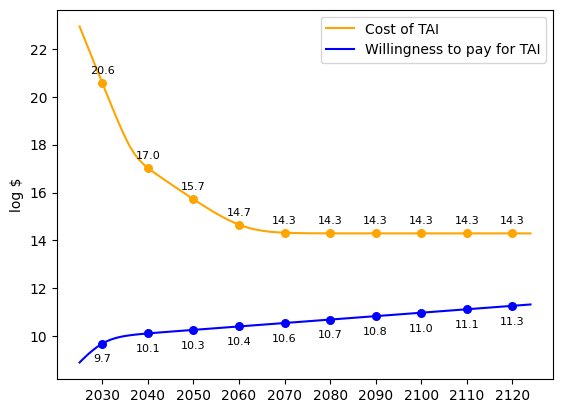

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 30.9 log FLOP (~7.9 nonillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~881.5 quadrillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~577.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~395.5 million).
* This doubles every 1.1 year to a max of 0.237701% of GDP (initially ~60.0 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 30.9 logFLOP which costs 13.0 log 2025$USD to buy vs. WTP at 8.6 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 30.7 logFLOP which costs 12.6 log 2025$USD to buy vs. WTP at 8.9 (buys 26.9 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 30.4 logFLOP which costs 12.3 log 2025$USD to buy vs. WTP at 9.1 (buys 27.3 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 30.2 logFLOP which cos

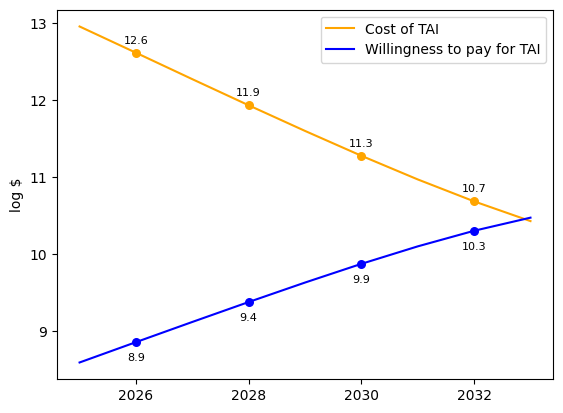

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 34.3 log FLOP (~20.0 decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.0 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2.1 septillion) per 2025$USD.
* We are initially willing to pay 9.8 log 2025$USD (~6.1 billion).
* This doubles every 1.3 year to a max of 0.103001% of GDP (initially ~25.8 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 34.3 logFLOP which costs 15.5 log 2025$USD to buy vs. WTP at 9.7 (buys 28.5 log FLOP or 28.5 2025-log-eFLOP)
2026 - TAI takes 33.9 logFLOP which costs 15.0 log 2025$USD to buy vs. WTP at 9.9 (buys 28.8 log FLOP or 29.2 2025-log-eFLOP)
2027 - TAI takes 33.4 logFLOP which costs 14.4 log 2025$USD to buy vs. WTP at 10.0 (buys 29.0 log FLOP or 29.9 2025-log-eFLOP)
2028 - TAI takes 33.0 logFLOP which costs 1

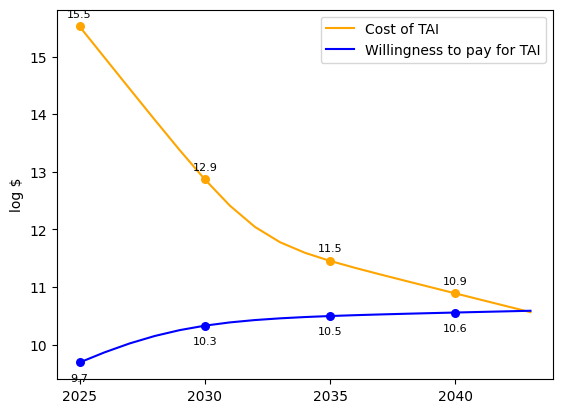

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 31.1 log FLOP (~12.6 nonillion) for transformative capabilities.
* Every 3.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~20.6 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~8.4 septillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~261.6 million).
* This doubles every 0.4 year to a max of 0.003043% of GDP (initially ~762.5 million 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 31.1 logFLOP which costs 11.8 log 2025$USD to buy vs. WTP at 8.3 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 31.0 logFLOP which costs 11.6 log 2025$USD to buy vs. WTP at 8.7 (buys 28.1 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 30.9 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 8.9 (buys 28.4 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 30.8 logFLOP which cost

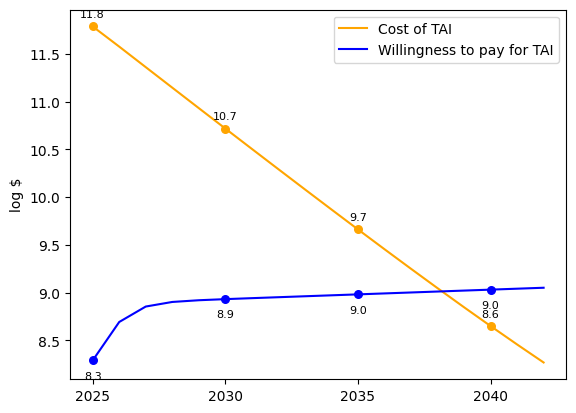

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 39.7 log FLOP (~5.0 million decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~7.1 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~54.2 septillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.2 billion).
* This doubles every 1.4 year to a max of 0.014616% of GDP (initially ~3.7 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 39.7 logFLOP which costs 20.9 log 2025$USD to buy vs. WTP at 9.2 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 39.3 logFLOP which costs 20.3 log 2025$USD to buy vs. WTP at 9.3 (buys 28.3 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 39.0 logFLOP which costs 19.8 log 2025$USD to buy vs. WTP at 9.4 (buys 28.6 log FLOP or 29.3 2025-log-eFLOP)
2028 - TAI takes 38.6 logFLOP which 

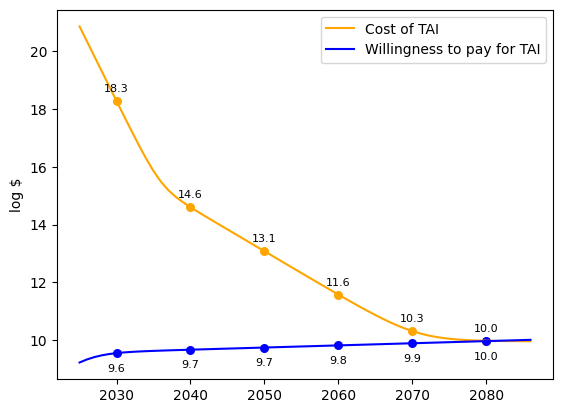

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 28.6 log FLOP (~39.8 octillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.3 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~458.5 million).
* This doubles every 0.6 year to a max of 0.021681% of GDP (initially ~5.4 billion 2025$USD).
* GDP grows at a rate of 1.006x per year.
---
2025 - TAI takes 28.6 logFLOP which costs 10.2 log 2025$USD to buy vs. WTP at 8.6 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 28.3 logFLOP which costs 9.8 log 2025$USD to buy vs. WTP at 9.1 (buys 27.6 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 28.0 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 9.4 (buys 28.0 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 27.8 logFLOP which costs 9.

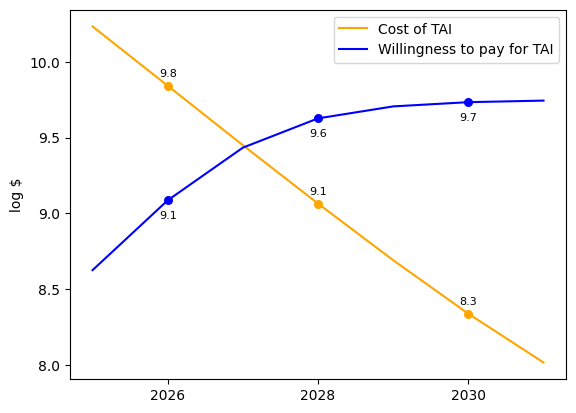

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 39.7 log FLOP (~5.0 million decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.0 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~394.8 million).
* This doubles every 0.9 year to a max of 0.186755% of GDP (initially ~47.0 billion 2025$USD).
* GDP grows at a rate of 1.006x per year.
---
2025 - TAI takes 39.7 logFLOP which costs 21.4 log 2025$USD to buy vs. WTP at 8.6 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 39.3 logFLOP which costs 20.9 log 2025$USD to buy vs. WTP at 8.9 (buys 27.3 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 38.8 logFLOP which costs 20.3 log 2025$USD to buy vs. WTP at 9.3 (buys 27.8 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 38.4 logFLOP whic

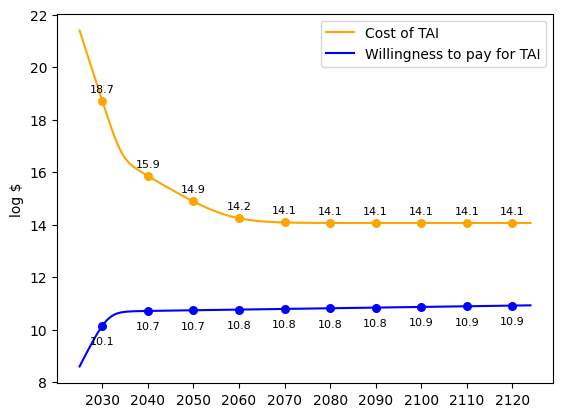

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 27.3 log FLOP (~2.0 octillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.4 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~14.5 sextillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.5 billion).
* This doubles every 0.9 year to a max of 0.047811% of GDP (initially ~12.1 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 27.3 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 9.3 (buys 28.0 log FLOP or 28.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 4 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur

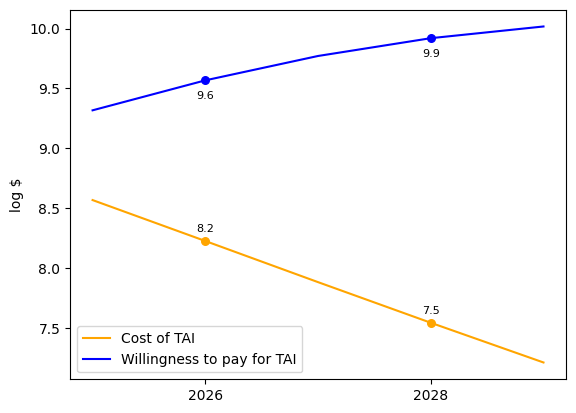

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 26.7 log FLOP (~501.2 septillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.2 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 26.1 log FLOP (~116.1 septillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.6 billion).
* This doubles every 1.1 year to a max of 0.36114% of GDP (initially ~91.3 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 26.7 logFLOP which costs 8.2 log 2025$USD to buy vs. WTP at 9.2 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 3 

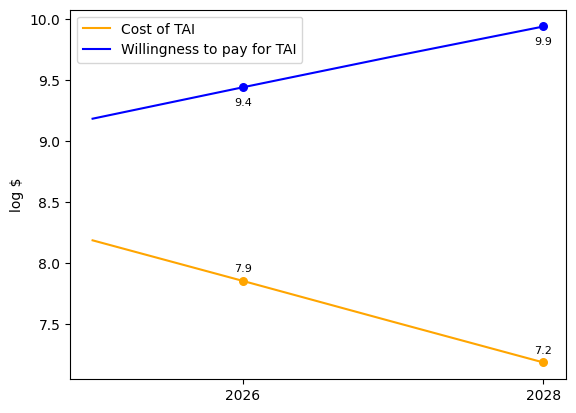

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 32.2 log FLOP (~158.5 nonillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~219.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~408.3 million).
* This doubles every 0.6 year to a max of 0.004595% of GDP (initially ~1.2 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 32.2 logFLOP which costs 14.0 log 2025$USD to buy vs. WTP at 8.5 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 32.0 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 8.8 (buys 27.1 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 31.7 logFLOP which costs 13.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.4 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 31.5 logFLOP which cos

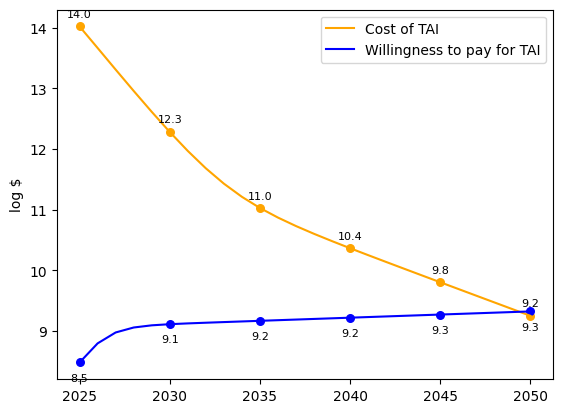

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 32.5 log FLOP (~316.2 nonillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.6 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~1.7 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.3 billion).
* This doubles every 0.9 year to a max of 0.028681% of GDP (initially ~7.3 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 32.5 logFLOP which costs 13.4 log 2025$USD to buy vs. WTP at 9.0 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 32.2 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 9.3 (buys 28.5 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 32.0 logFLOP which costs 12.7 log 2025$USD to buy vs. WTP at 9.5 (buys 28.8 log FLOP or 29.3 2025-log-eFLOP)
2028 - TAI takes 31.7 logFLOP which costs 

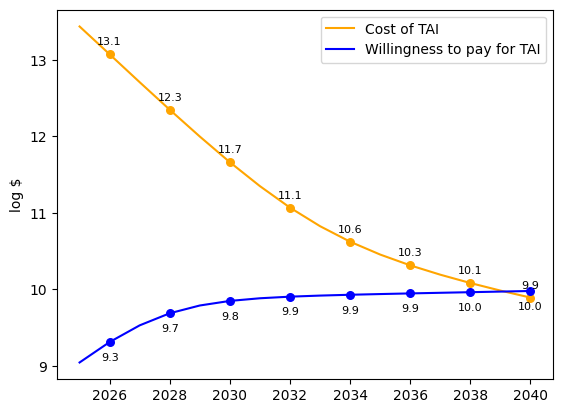

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 50.3 log FLOP (~199.5 quadrillion decillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 7 log reductions possible.
* FLOP start at a cost of 17.0 log FLOP (~106.2 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~979.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~976.9 million).
* This doubles every 1.5 year to a max of 0.166687% of GDP (initially ~42.3 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 50.3 logFLOP which costs 33.3 log 2025$USD to buy vs. WTP at 9.0 (buys 26.0 log FLOP or 26.0 2025-log-eFLOP)
2026 - TAI takes 50.1 logFLOP which costs 32.9 log 2025$USD to buy vs. WTP at 9.2 (buys 26.3 log FLOP or 26.5 2025-log-eFLOP)
2027 - TAI takes 49.8 logFLOP which costs 32.6 log 2025$USD to buy vs. WTP at 9.4 (buys 26.6 log FLOP or 27.1 2025-log-eFLOP)
2028 - TAI takes 49.6 lo

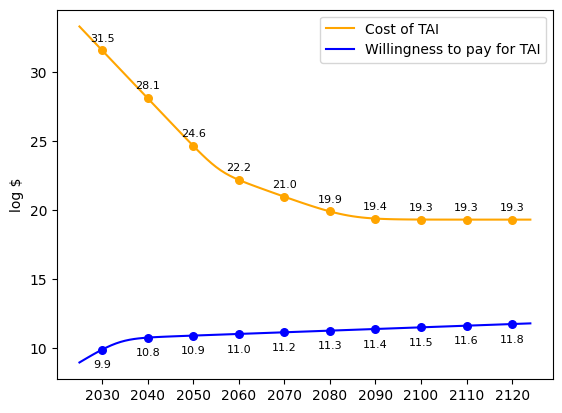

-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 27.8 log FLOP (~6.3 octillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.9 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~17.2 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~986.6 million).
* This doubles every 0.7 year to a max of 0.292044% of GDP (initially ~73.6 billion 2025$USD).
* GDP grows at a rate of 1.035x per year.
---
2025 - TAI takes 27.8 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 27.6 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 9.4 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.796 -> Nonscaling delay occured
-- -- this delay is 3 years (tot

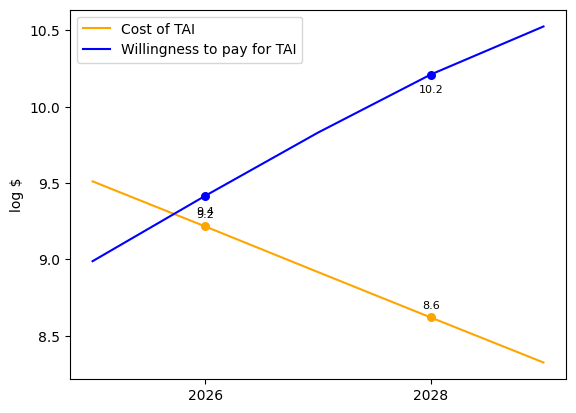

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 32.8 log FLOP (~631.0 nonillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~1.1 septillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 1.0 year to a max of 0.25328% of GDP (initially ~63.9 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 32.8 logFLOP which costs 14.6 log 2025$USD to buy vs. WTP at 9.2 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 32.5 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 9.5 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 32.1 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 9.8 (buys 28.2 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 31.8 logFLOP which costs 13

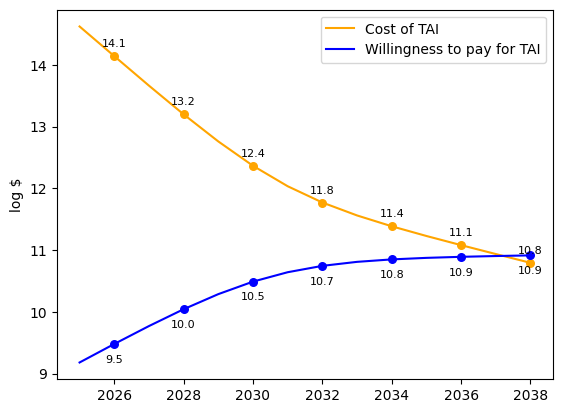

-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 28.8 log FLOP (~63.1 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.6 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~25.0 septillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~2.2 billion).
* This doubles every 1.8 year to a max of 0.029586% of GDP (initially ~7.4 billion 2025$USD).
* GDP grows at a rate of 1.008x per year.
---
2025 - TAI takes 28.8 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 9.2 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 28.5 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 9.4 (buys 28.4 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 28.2 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 9.5 (buys 28.6 log FLOP or 29.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1535 -> N

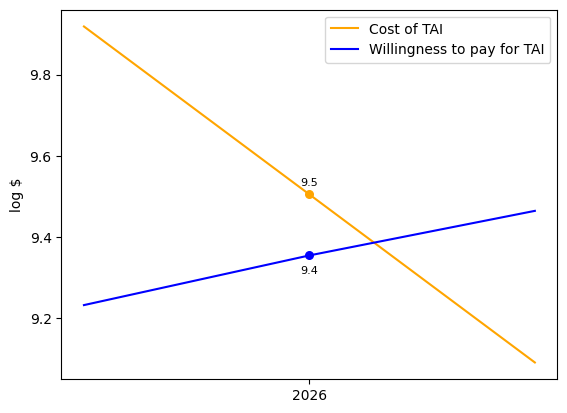

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 26.8 log FLOP (~631.0 septillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.4 quintillion) per 2025$USD.
* Every 1.5 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~1.9 septillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 0.5 year to a max of 0.102999% of GDP (initially ~25.9 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 26.8 logFLOP which costs 8.2 log 2025$USD to buy vs. WTP at 9.1 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 3 m

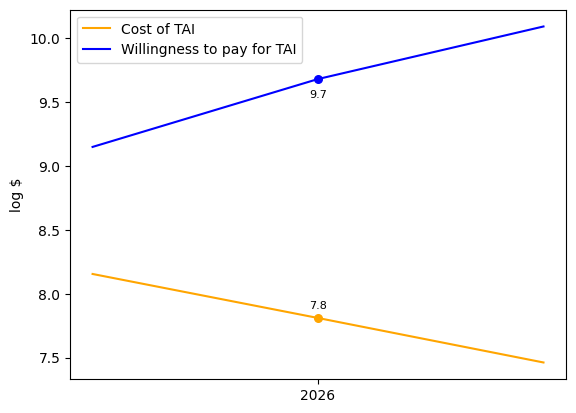

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 27.5 log FLOP (~3.2 octillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.3 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~3.7 septillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.6 billion).
* This doubles every 1.6 year to a max of 0.053989% of GDP (initially ~13.5 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 27.5 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 9.3 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 5 more

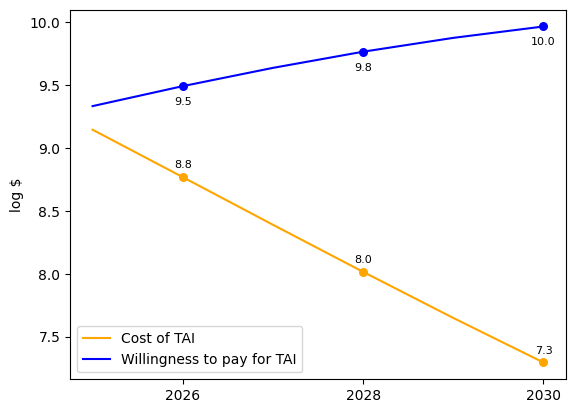

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 28.4 log FLOP (~25.1 octillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~43.8 sextillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.6 billion).
* This doubles every 0.5 year to a max of 0.029843% of GDP (initially ~7.5 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 28.4 logFLOP which costs 10.3 log 2025$USD to buy vs. WTP at 9.1 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 28.1 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 9.5 (buys 27.7 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 27.8 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 9.8 (buys 28.1 log FLOP or 28.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1535 -> 

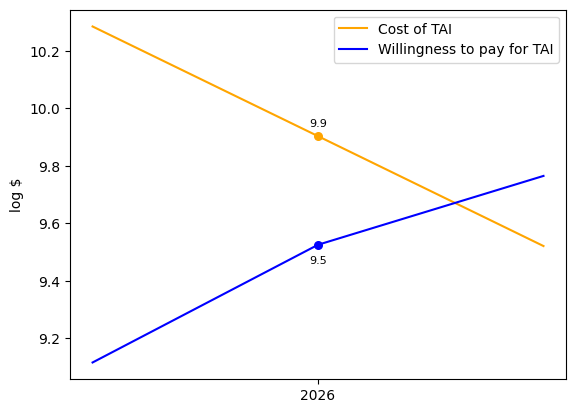

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 34.8 log FLOP (~63.1 decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~16.9 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 26.0 log FLOP (~92.2 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~587.1 million).
* This doubles every 2.0 year to a max of 0.03355% of GDP (initially ~8.5 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 34.8 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 8.7 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
2026 - TAI takes 34.5 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 8.9 (buys 28.3 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 34.2 logFLOP which costs 14.7 log 2025$USD to buy vs. WTP at 9.0 (buys 28.5 log FLOP or 29.1 2025-log-eFLOP)
2028 - TAI takes 33.9 logFLOP which costs

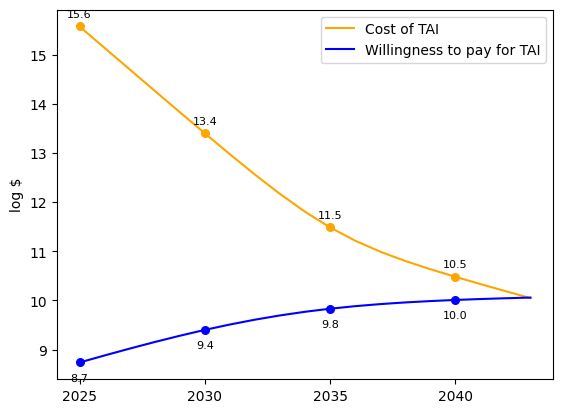

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 27.2 log FLOP (~1.6 octillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.4 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 20.2 log FLOP (~144.4 quintillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~866.5 million).
* This doubles every 1.2 year to a max of 0.011051% of GDP (initially ~2.8 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 27.2 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 8.8 (buys 27.5 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 4 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not oc

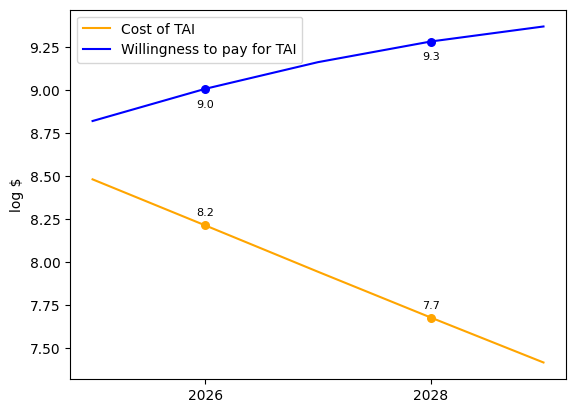

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 28.4 log FLOP (~25.1 octillion) for transformative capabilities.
* Every 2.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~707.0 quadrillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~506.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~748.3 million).
* This doubles every 1.3 year to a max of 0.051095% of GDP (initially ~12.9 billion 2025$USD).
* GDP grows at a rate of 1.013x per year.
---
2025 - TAI takes 28.4 logFLOP which costs 10.6 log 2025$USD to buy vs. WTP at 8.8 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 28.3 logFLOP which costs 10.3 log 2025$USD to buy vs. WTP at 9.1 (buys 27.0 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 28.2 logFLOP which costs 10.1 log 2025$USD to buy vs. WTP at 9.3 (buys 27.4 log FLOP or 27.6 2025-log-eFLOP)
2028 - TAI takes 28.1 logFLOP which c

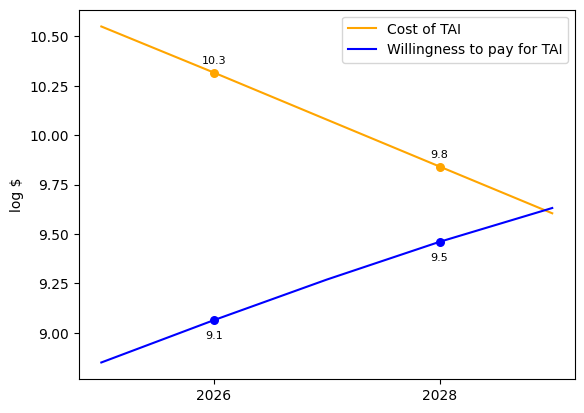

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 30.1 log FLOP (~1.3 nonillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.1 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~781.1 million).
* This doubles every 0.4 year to a max of 0.188107% of GDP (initially ~46.9 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 30.1 logFLOP which costs 11.2 log 2025$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 29.8 logFLOP which costs 10.8 log 2025$USD to buy vs. WTP at 9.7 (buys 28.8 log FLOP or 29.0 2025-log-eFLOP)
2027 - TAI takes 29.5 logFLOP which costs 10.3 log 2025$USD to buy vs. WTP at 10.3 (buys 29.5 log FLOP or 30.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.153

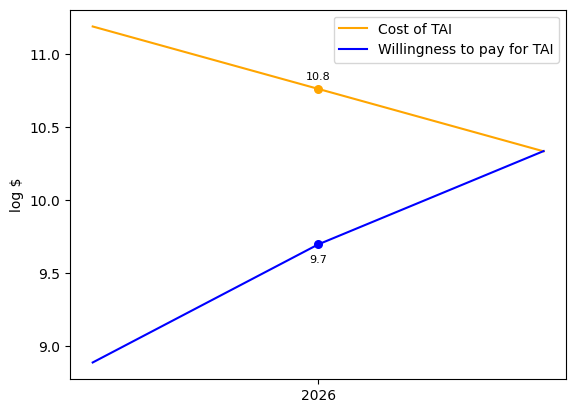

-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 37.9 log FLOP (~79.4 thousand decillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.2 septillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~2.9 billion).
* This doubles every 0.8 year to a max of 0.138117% of GDP (initially ~34.6 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 37.9 logFLOP which costs 19.7 log 2025$USD to buy vs. WTP at 9.4 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 37.7 logFLOP which costs 19.4 log 2025$USD to buy vs. WTP at 9.8 (buys 28.1 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 37.5 logFLOP which costs 19.1 log 2025$USD to buy vs. WTP at 10.1 (buys 28.5 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 37.3 logFLOP whi

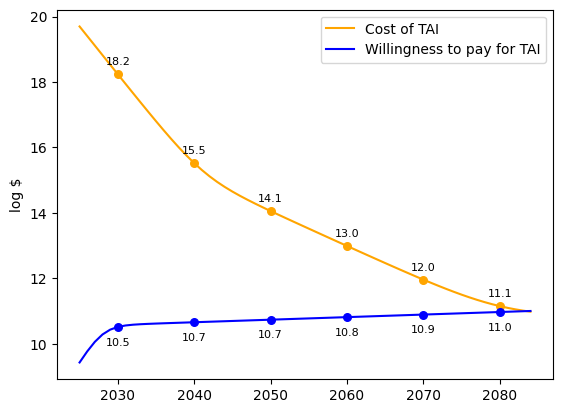

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 25.9 log FLOP (~79.4 septillion) for transformative capabilities.
* Every 2.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.2 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 25.3 log FLOP (~17.8 septillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.3 billion).
* This doubles every 0.5 year to a max of 0.141159% of GDP (initially ~35.4 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 25.9 logFLOP which costs 7.6 log 2025$USD to buy vs. WTP at 9.3 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
--- /!\ TAI CREATED in 2025
-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 30

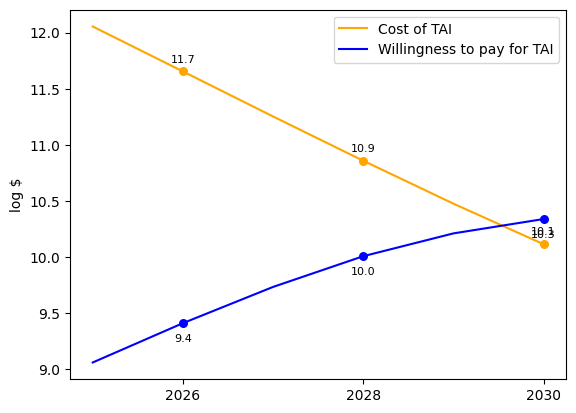

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 28.5 log FLOP (~31.6 octillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.0 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~5.8 septillion) per 2025$USD.
* We are initially willing to pay 9.8 log 2025$USD (~6.2 billion).
* This doubles every 0.5 year to a max of 0.065556% of GDP (initially ~16.4 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 28.5 logFLOP which costs 10.2 log 2025$USD to buy vs. WTP at 9.7 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
2026 - TAI takes 28.3 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 10.0 (buys 28.4 log FLOP or 28.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.796 -> Nonscaling delay occured
-- -- this delay is 3 years (tot

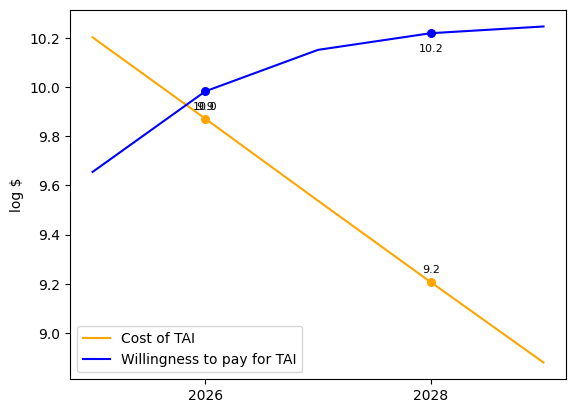

-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 31.9 log FLOP (~79.4 nonillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.1 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 19.9 log FLOP (~75.1 quintillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.6 billion).
* This doubles every 1.1 year to a max of 0.012068% of GDP (initially ~3.0 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 31.9 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 9.0 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 31.7 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 9.2 (buys 27.3 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 31.5 logFLOP which costs 13.2 log 2025$USD to buy vs. WTP at 9.3 (buys 27.6 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 31.2 logFLOP which costs 

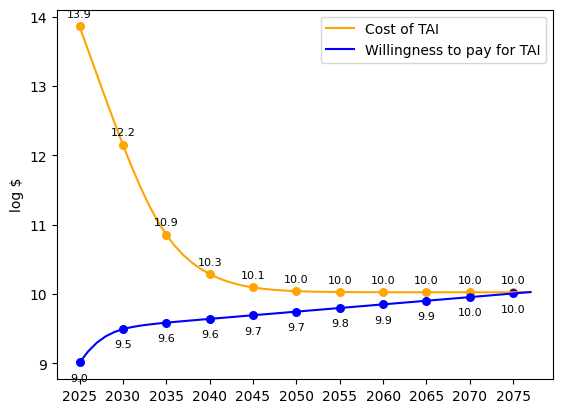

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 38.3 log FLOP (~199.5 thousand decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.3 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~10.2 septillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~2.1 billion).
* This doubles every 1.8 year to a max of 0.012235% of GDP (initially ~3.1 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 38.3 logFLOP which costs 19.5 log 2025$USD to buy vs. WTP at 9.1 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 37.9 logFLOP which costs 19.0 log 2025$USD to buy vs. WTP at 9.2 (buys 28.1 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 37.5 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 9.3 (buys 28.3 log FLOP or 29.1 2025-log-eFLOP)
2028 - TAI takes 37.1 logFLOP whi

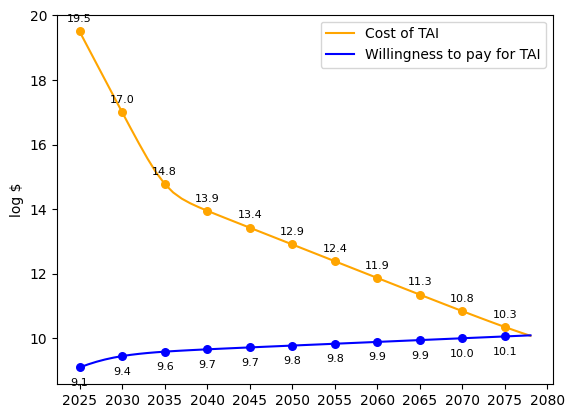

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 27.8 log FLOP (~6.3 octillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.6 quintillion) per 2025$USD.
* Every 3.2 years they get 2x cheaper, to a maximum of 27.0 log FLOP (~1.0 octillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.5 billion).
* This doubles every 2.0 year to a max of 0.025976% of GDP (initially ~6.5 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 27.8 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 9.3 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 27.5 logFLOP which costs 9.0 log 2025$USD to buy vs. WTP at 9.4 (buys 27.9 log FLOP or 28.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.796 -> Nonscaling issue d

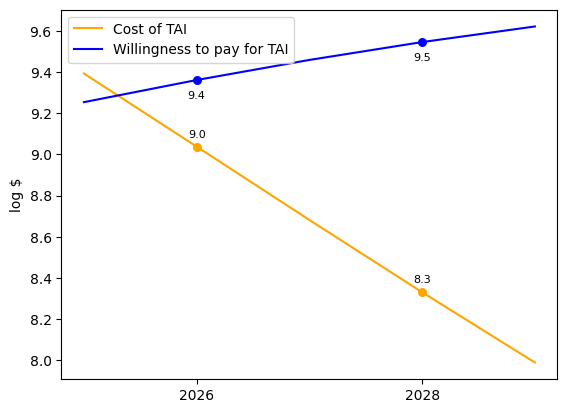

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~44.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.5 billion).
* This doubles every 1.0 year to a max of 0.04881% of GDP (initially ~12.3 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 27.6 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 9.3 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 27.4 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 9.6 (buys 27.9 log FLOP or 28.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.796 -> Nonscaling delay occured
-- -- this delay is 3 years (total 

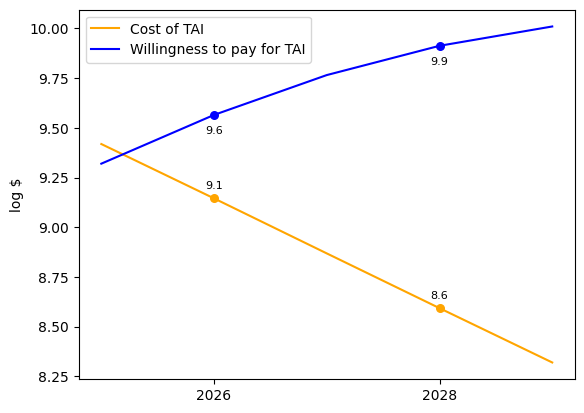

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 29.5 log FLOP (~316.2 octillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.1 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2.0 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.2 year to a max of 0.054518% of GDP (initially ~13.8 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 29.5 logFLOP which costs 11.5 log 2025$USD to buy vs. WTP at 9.0 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 29.4 logFLOP which costs 11.2 log 2025$USD to buy vs. WTP at 9.2 (buys 27.4 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 29.2 logFLOP which costs 11.0 log 2025$USD to buy vs. WTP at 9.5 (buys 27.7 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 29.1 logFLOP which costs 

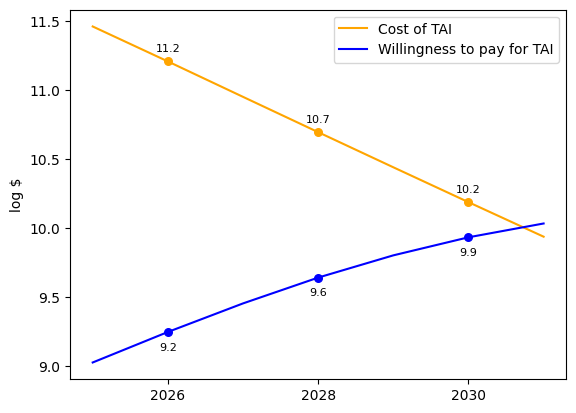

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 31.1 log FLOP (~12.6 nonillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.0 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~12.8 septillion) per 2025$USD.
* We are initially willing to pay 9.9 log 2025$USD (~7.9 billion).
* This doubles every 0.9 year to a max of 0.041967% of GDP (initially ~10.6 billion 2025$USD).
* GDP grows at a rate of 1.011x per year.
---
2025 - TAI takes 31.1 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 9.7 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 30.9 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 9.8 (buys 28.0 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 30.7 logFLOP which costs 12.5 log 2025$USD to buy vs. WTP at 9.9 (buys 28.2 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 30.5 logFLOP which costs 

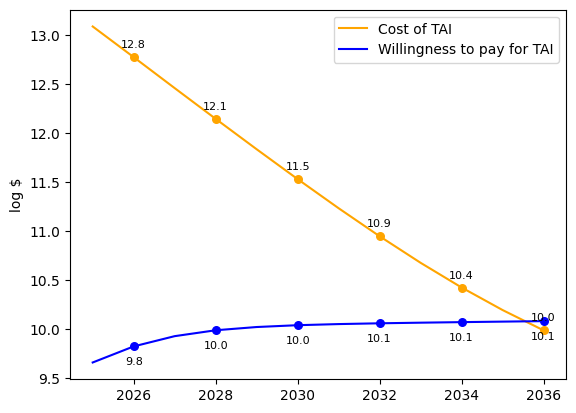

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 37.6 log FLOP (~39.8 thousand decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.2 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~455.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~581.3 million).
* This doubles every 0.6 year to a max of 0.004382% of GDP (initially ~1.1 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 37.6 logFLOP which costs 19.3 log 2025$USD to buy vs. WTP at 8.6 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 37.3 logFLOP which costs 18.9 log 2025$USD to buy vs. WTP at 8.8 (buys 27.3 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 37.1 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 9.0 (buys 27.6 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 36.8 logFLOP w

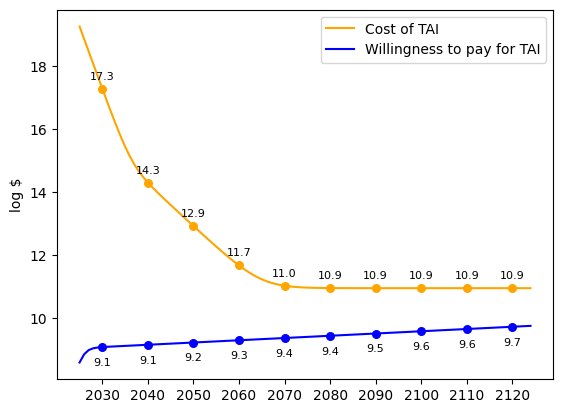

-
-
## SAMPLE RUN 39 ##

In this simulation:
* It takes 36.5 log FLOP (~3.2 thousand decillion) for transformative capabilities.
* Every 2.2 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.7 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.4 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~555.9 million).
* This doubles every 0.8 year to a max of 0.018582% of GDP (initially ~4.7 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 36.5 logFLOP which costs 17.7 log 2025$USD to buy vs. WTP at 8.7 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 36.4 logFLOP which costs 17.5 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 36.2 logFLOP which costs 17.3 log 2025$USD to buy vs. WTP at 9.3 (buys 28.3 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 36.1 logFLOP whic

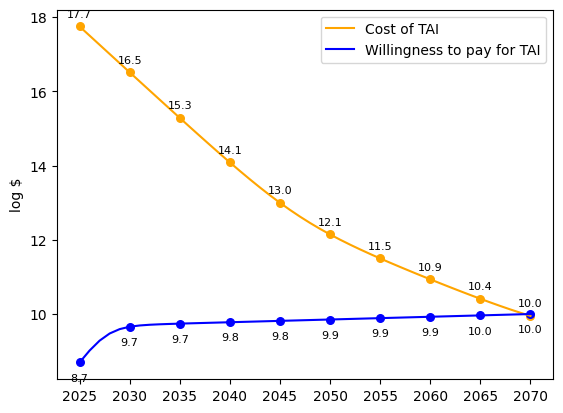

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 2.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~641.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~918.4 million).
* This doubles every 1.0 year to a max of 0.044811% of GDP (initially ~11.3 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 27.6 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 8.9 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 27.5 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 9.2 (buys 27.5 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.796 -> Nonscaling d

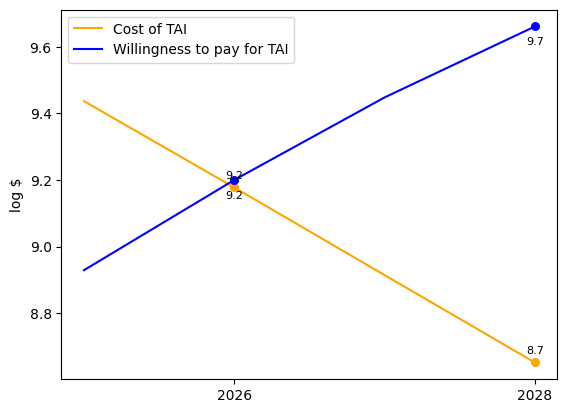

-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 34.5 log FLOP (~31.6 decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.8 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~116.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~860.9 million).
* This doubles every 1.4 year to a max of 0.024644% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 34.5 logFLOP which costs 16.2 log 2025$USD to buy vs. WTP at 8.9 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 34.2 logFLOP which costs 15.9 log 2025$USD to buy vs. WTP at 9.1 (buys 27.4 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 34.0 logFLOP which costs 15.5 log 2025$USD to buy vs. WTP at 9.2 (buys 27.7 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 33.7 logFLOP which cost

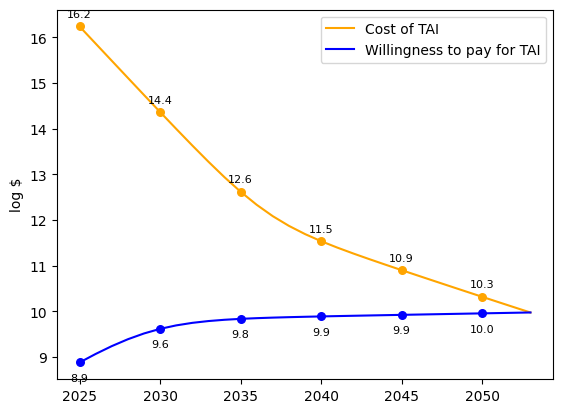

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 27.4 log FLOP (~2.5 octillion) for transformative capabilities.
* Every 3.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.0 quintillion) per 2025$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~494.5 million).
* This doubles every 1.0 year to a max of 0.146959% of GDP (initially ~37.1 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 27.4 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 2 m

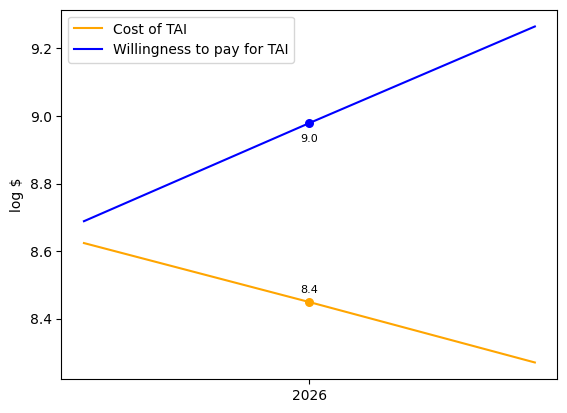

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 26.0 log FLOP (~100.0 septillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.0 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~55.9 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 0.8 year to a max of 0.617656% of GDP (initially ~155.2 billion 2025$USD).
* GDP grows at a rate of 1.008x per year.
---
2025 - TAI takes 26.0 logFLOP which costs 8.0 log 2025$USD to buy vs. WTP at 9.1 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 4 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not o

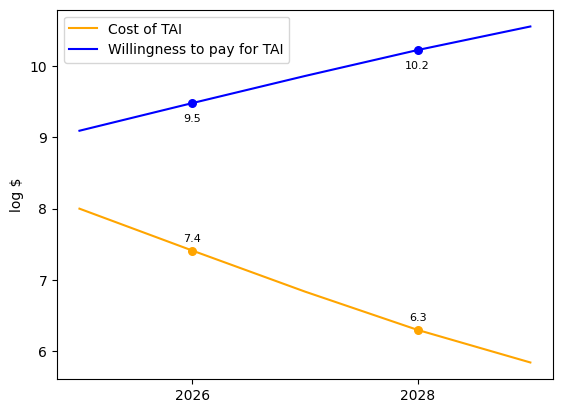

-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes 25.9 log FLOP (~79.4 septillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~454.1 million).
* This doubles every 1.2 year to a max of 0.019025% of GDP (initially ~4.8 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 25.9 logFLOP which costs 7.7 log 2025$USD to buy vs. WTP at 8.6 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 2 m

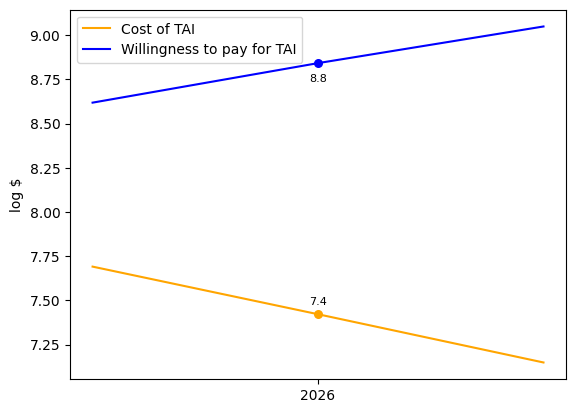

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 41.9 log FLOP (~794.3 million decillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~935.8 quadrillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~59.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~930.3 million).
* This doubles every 0.9 year to a max of 0.052992% of GDP (initially ~13.3 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 41.9 logFLOP which costs 23.9 log 2025$USD to buy vs. WTP at 8.9 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 41.7 logFLOP which costs 23.6 log 2025$USD to buy vs. WTP at 9.2 (buys 27.4 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 41.5 logFLOP which costs 23.3 log 2025$USD to buy vs. WTP at 9.5 (buys 27.8 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 41.4 logFLOP 

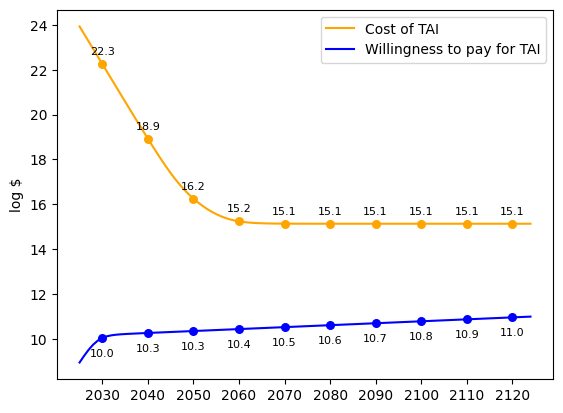

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 32.1 log FLOP (~125.9 nonillion) for transformative capabilities.
* Every 2.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.0 quintillion) per 2025$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~35.2 sextillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.7 billion).
* This doubles every 0.6 year to a max of 0.033446% of GDP (initially ~8.4 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 32.1 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 9.3 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 32.0 logFLOP which costs 13.6 log 2025$USD to buy vs. WTP at 9.6 (buys 28.0 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 31.9 logFLOP which costs 13.4 log 2025$USD to buy vs. WTP at 9.8 (buys 28.3 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 31.8 logFLOP which costs 

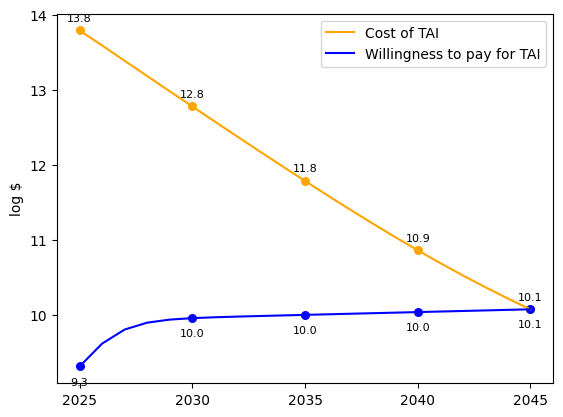

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 42.4 log FLOP (~2.5 billion decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 3.1 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~915.2 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~325.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.9 billion).
* This doubles every 1.4 year to a max of 0.133933% of GDP (initially ~33.8 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 42.4 logFLOP which costs 24.4 log 2025$USD to buy vs. WTP at 9.3 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 42.0 logFLOP which costs 24.0 log 2025$USD to buy vs. WTP at 9.5 (buys 27.5 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 41.7 logFLOP which costs 23.5 log 2025$USD to buy vs. WTP at 9.7 (buys 27.8 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 41.3 logFLOP 

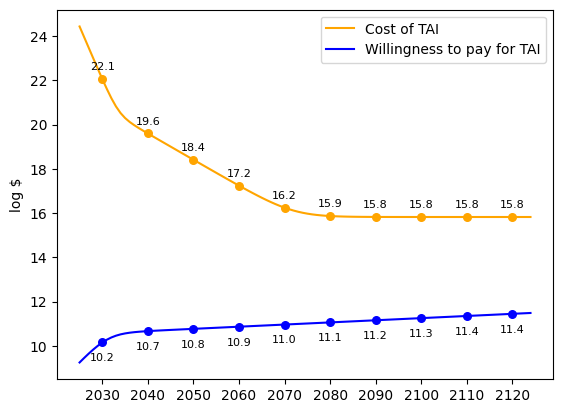

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 37.0 log FLOP (~10.0 thousand decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.5 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~6.7 septillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.3 billion).
* This doubles every 0.4 year to a max of 0.086963% of GDP (initially ~21.9 billion 2025$USD).
* GDP grows at a rate of 1.006x per year.
---
2025 - TAI takes 37.0 logFLOP which costs 18.6 log 2025$USD to buy vs. WTP at 9.3 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 36.5 logFLOP which costs 18.0 log 2025$USD to buy vs. WTP at 9.9 (buys 28.5 log FLOP or 28.9 2025-log-eFLOP)
2027 - TAI takes 36.1 logFLOP which costs 17.4 log 2025$USD to buy vs. WTP at 10.2 (buys 28.9 log FLOP or 29.8 2025-log-eFLOP)
2028 - TAI takes 35.6 logFLOP whi

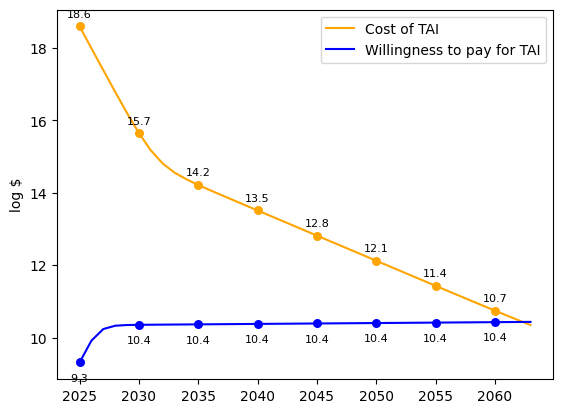

-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 39.5 log FLOP (~3.2 million decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~642.2 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~135.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.4 billion).
* This doubles every 0.7 year to a max of 0.087996% of GDP (initially ~22.1 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 39.5 logFLOP which costs 21.7 log 2025$USD to buy vs. WTP at 9.5 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 39.3 logFLOP which costs 21.4 log 2025$USD to buy vs. WTP at 9.8 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 39.1 logFLOP which costs 21.0 log 2025$USD to buy vs. WTP at 10.1 (buys 28.1 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 38.8 logFLOP w

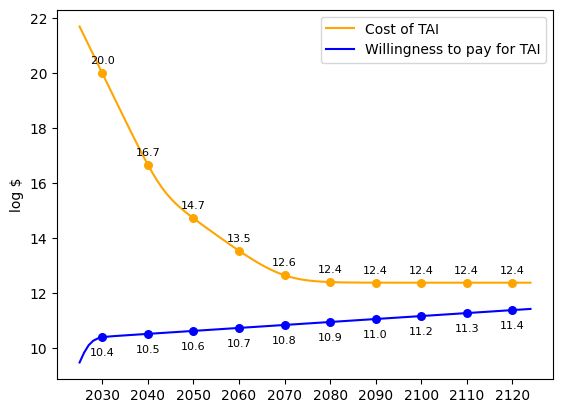

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 29.9 log FLOP (~794.3 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.5 log FLOP (~335.3 quadrillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~3.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~384.5 million).
* This doubles every 1.5 year to a max of 0.045216% of GDP (initially ~11.3 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 29.9 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 8.6 (buys 26.1 log FLOP or 26.1 2025-log-eFLOP)
2026 - TAI takes 29.6 logFLOP which costs 12.0 log 2025$USD to buy vs. WTP at 8.8 (buys 26.4 log FLOP or 26.7 2025-log-eFLOP)
2027 - TAI takes 29.3 logFLOP which costs 11.6 log 2025$USD to buy vs. WTP at 8.9 (buys 26.7 log FLOP or 27.3 2025-log-eFLOP)
2028 - TAI takes 29.0 logFLOP which co

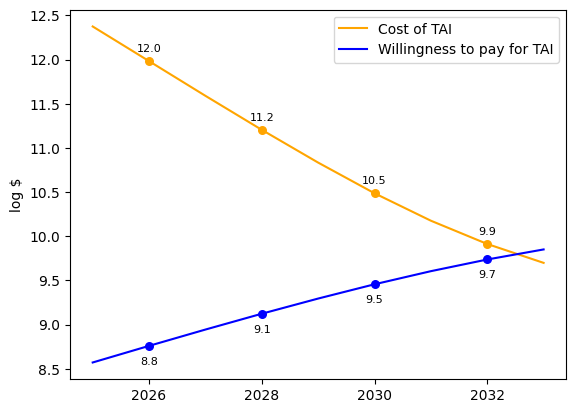

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 40.8 log FLOP (~63.1 million decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~14.9 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~74.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~538.0 million).
* This doubles every 2.2 year to a max of 0.014668% of GDP (initially ~3.6 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 40.8 logFLOP which costs 21.6 log 2025$USD to buy vs. WTP at 8.7 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 40.6 logFLOP which costs 21.3 log 2025$USD to buy vs. WTP at 8.8 (buys 28.1 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 40.4 logFLOP which costs 21.0 log 2025$USD to buy vs. WTP at 8.9 (buys 28.3 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 40.1 logFLOP wh

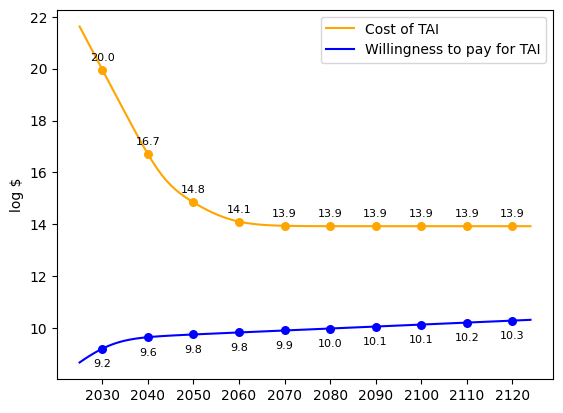

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 27.0 log FLOP (~1.0 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.7 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~51.3 sextillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.8 billion).
* This doubles every 0.3 year to a max of 0.023393% of GDP (initially ~5.9 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 27.0 logFLOP which costs 8.0 log 2025$USD to buy vs. WTP at 9.1 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 2 mor

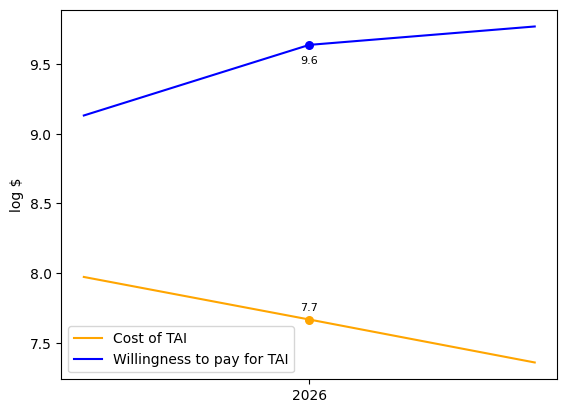

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.9 quintillion) per 2025$USD.
* Every 1.9 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~564.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~643.3 million).
* This doubles every 0.8 year to a max of 0.013499% of GDP (initially ~3.4 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 27.6 logFLOP which costs 9.3 log 2025$USD to buy vs. WTP at 8.7 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 27.4 logFLOP which costs 9.0 log 2025$USD to buy vs. WTP at 9.0 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.796 -> Nonscaling de

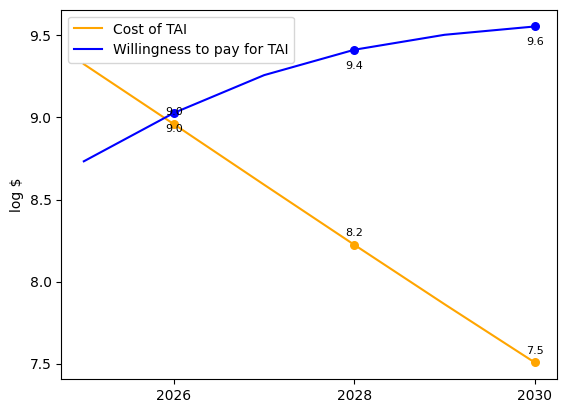

In [16]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [17]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2025-01-25 00:28:55.387997
